In [1]:
%load_ext autoreload
%autoreload 2

# Imports

In [2]:
import numpy as np
import jax
import jax.numpy as jnp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import diffrax as dfx
from typing import List

from functools import partial
import os
import sys

jax.config.update('jax_platform_name', 'gpu')

if __package__ is None:

    module_path = os.path.abspath(os.path.join('..'))
    sys.path.append(module_path)

    __package__ = os.path.basename(module_path)


# jupyter nbconvert --to notebook --execute 23_Monte_Carlo_adaptability_2.ipynb --output=23_Monte_Carlo_adaptability_2_large.ipynb --ExecutePreprocessor.timeout=-1
np.random.seed(0)
jax.devices()

[cuda(id=0), cuda(id=1)]

In [3]:
from synbio_morpher.srv.parameter_prediction.simulator import make_piecewise_stepcontrol
from synbio_morpher.utils.misc.type_handling import flatten_listlike
from synbio_morpher.utils.modelling.physical import eqconstant_to_rates, equilibrium_constant_reparameterisation
from synbio_morpher.utils.modelling.deterministic import bioreaction_sim_dfx_expanded
from synbio_morpher.utils.modelling.solvers import get_diffrax_solver, make_stepsize_controller, simulate_steady_states
from synbio_morpher.utils.results.analytics.timeseries import calculate_adaptation, compute_peaks, compute_adaptability_full


# Set up test circuits

In [4]:
def make_species_bound(species_unbound):
    return sorted(set(flatten_listlike([['-'.join(sorted([x, y])) for x in species_unbound] for y in species_unbound])))


# RNA circuit settings
species_unbound = ['RNA_0', 'RNA_1', 'RNA_2']
species_bound = make_species_bound(species_unbound)
species = species_unbound + species_bound
species_signal = ['RNA_0']
species_output = ['RNA_2']
# species_output = ['RNA_1', 'RNA_2']
species_nonsignal = [s for s in species_unbound if s not in species_signal]
idxs_signal = np.array([species.index(s) for s in species_signal])
idxs_output = np.array([species.index(s) for s in species_output])
idxs_unbound = np.array([species.index(s) for s in species_unbound])
idxs_bound = np.array([species.index(s) for s in species_bound])
signal_onehot = np.array([1 if s in idxs_signal else 0 for s in np.arange(len(species))])

# Dynamic Simulation parameters
k_a = 0.00150958097
signal_target = 2
t0 = 0
t1 = 500
ts = np.linspace(t0, t1, 500)
tmax = 1000
dt0 = 0.005555558569638981
dt1_factor = 5
dt1 = dt0 * dt1_factor
max_steps = 16**4 * 10
use_sensitivity_func1 = False
sim_method = 'Dopri5'
stepsize_controller = 'adaptive'
threshold_steady_state = 0.01
batch_size = 100

# MC parameters
total_steps = 20
total_samples = 2000
choose_max = int(total_samples * 0.1)
diversity = 0.2  # Sensitivity max to add into next chosen circuits
mutation_scale = 0.1
n_circuits_display = 30
N0 = 200
y00 = np.array([[N0] * len(species_unbound) + [0] * len(species_bound)]).astype(np.float32)
y00 = np.repeat(y00, repeats=total_samples, axis=0)

# Reactions
energies = np.random.rand(total_samples, len(np.tril_indices(len(species_unbound))[0]))
energies = np.interp(energies, (energies.min(), energies.max()), (-25, 0))
eqconstants = jax.vmap(partial(equilibrium_constant_reparameterisation, initial=N0))(energies)
forward_rates, reverse_rates = eqconstant_to_rates(eqconstants, k_a)
# forward_rates = np.array(list(map(lambda r: r[np.triu_indices(len(species_unbound))], forward_rates)))
forward_rates = forward_rates[0]
# reverse_rates = np.array(list(map(lambda r: r[np.triu_indices(len(species_unbound))], reverse_rates)))

inputs = np.array([
    [2, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 0, 0, 0, 0, 0, 0, 0],
    [1, 0, 1, 0, 0, 0, 0, 0, 0],
    [0, 2, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 0, 0, 0, 0, 0, 0],
    [0, 0, 2, 0, 0, 0, 0, 0, 0],
], dtype=np.float64)
outputs = np.array([
    [0, 0, 0, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 1],
], dtype=np.float64)

# Initialise simulations

In [5]:
sim_func = jax.jit(jax.vmap(
    partial(bioreaction_sim_dfx_expanded,
            t0=t0, t1=t1, dt0=dt0,
            forward_rates=forward_rates,
            inputs=inputs,
            outputs=outputs,
            solver=get_diffrax_solver(
                sim_method),
            saveat=dfx.SaveAt(
                ts=jnp.linspace(t0, t1, 500)),  # int(np.min([500, t1-t0]))))
            stepsize_controller=make_stepsize_controller(t0, t1, dt0, dt1,
                                                         choice=stepsize_controller)
            )))
# sol_steady_states = jax.vmap(bioreaction_sim_dfx_expanded)(y00, reverse_rates)
# y01 = np.array(sol_steady_states.ys[:, -1])
# y01[:, np.array(idxs_signal)] = y01[:, np.array(idxs_signal)] * signal_target
# sol_signal = jax.vmap(bioreaction_sim_dfx_expanded)(y01, reverse_rates)

# Monte Carlo iterations

In [6]:
def choose_next(sol, idxs_signal, idxs_output, use_sensitivity_func1: bool, choose_max: int, diversity=0.):
    """ Choose circuits with highest adaptability """
    
    def get_next_idxs(analytic, n_chosen):
        idxs_next = jnp.where(jnp.sort(jnp.nanmax(analytic[:, idxs_output], axis=1))[
                            -n_chosen:].min() <= analytic[:, idxs_output])[0]
        return idxs_next[:n_chosen]
    
    def get_next_idxs_diversity(choose_max, diversity):
        n_chosen_a = int(np.ceil(choose_max * (1 - diversity)))
        n_chosen_s = int(np.floor(choose_max * diversity))
        idxs_next_a, idxs_next_s = (jnp.array([]), jnp.array([]))
        if n_chosen_a:
            idxs_next_a = get_next_idxs(adaptability, n_chosen_a)
        if n_chosen_s:
            idxs_next_s = get_next_idxs(sensitivity, n_chosen_s)
        # idxs_next_p = get_next_idxs(precision, int(np.floor(choose_max * diversity / 2)))
        idxs_next = jnp.unique(jnp.concatenate([idxs_next_a, idxs_next_s]))
        if len(idxs_next) < choose_max:
            idxs_next = jnp.concatenate([idxs_next, get_next_idxs(adaptability, choose_max - len(idxs_next))])
        return idxs_next

    ys0, ys1 = sol
    adaptability, sensitivity, precision = jax.vmap(partial(
        compute_adaptability_full, idx_sig=idxs_signal, use_sensitivity_func1=use_sensitivity_func1))(ys0, ys1)
    # idxs_next = jnp.argsort(adaptability[:, idxs_output], axis=0)[-choose_max:]
    if diversity:
        idxs_next = get_next_idxs_diversity(choose_max, diversity)
    else:
        idxs_next = get_next_idxs(adaptability, choose_max)
        
    return idxs_next.astype(jnp.int32), adaptability, sensitivity, precision


def mutate_expand(parents: jnp.ndarray, n_samples_per_parent, mutation_scale):
    min_param = parents.min()
    # Generate mutated samples from each parent
    mutated = jax.tree_util.tree_map(
                            lambda x: x + x * mutation_scale * np.random.randn(n_samples_per_parent, *x.shape), parents)
    mutated_nonzero = jnp.where(mutated < min_param, min_param, mutated)

    return mutated_nonzero.reshape(mutated_nonzero.shape[0] * mutated_nonzero.shape[1], *mutated_nonzero.shape[2:])


def simulate(y00, reverse_rates, sim_func, t0, t1, tmax, batch_size, threshold):
    
    def join_results(xs, xsb):
        if xs is None:
            xs = xsb
        else:
            xs = jnp.concatenate([xs, xsb], axis=0)
        return xs
    
    ys0, ts0, ys1, ts1 = [None] * 4
    for i, batch_step in enumerate(range(0, len(reverse_rates), batch_size)):
        i0, i1 = batch_step, jnp.minimum(batch_step + batch_size, len(reverse_rates))
        print(f'Simulating batch {i}: {i0} to {i1} / {len(reverse_rates)}')
        y00b, reverse_rates_b = y00[i0:i1], reverse_rates[i0:i1]
        ys0b, ts0b, ys1b, ts1b = simulate_core(y00b, reverse_rates_b, sim_func, t0, t1, tmax, threshold)
        
        # for xs, xsb in zip([ys0, ts0, ys1, ts1], [ys0b, ts0b, ys1b, ts1b]):
        ys0 = join_results(ys0, ys0b)
        ts0 = join_results(ts0, ts0b)
        ys1 = join_results(ys1, ys1b)
        ts1 = join_results(ts1, ts1b)
    
    return ys0, ts0, ys1, ts1
    
    
def simulate_core(y00, reverse_rates, sim_func, t0, t1, tmax, threshold):
    ys0, ts0 = simulate_steady_states(
        y0=y00, total_time=tmax, sim_func=sim_func,
        t0=t0, t1=t1,
        threshold=threshold,
        reverse_rates=reverse_rates,
    )
    y01 = np.array(ys0[:, -1])
    y01[:, np.array(idxs_signal)] = y01[:, np.array(
        idxs_signal)] * signal_target
    ys1, ts1 = simulate_steady_states(
        y0=y01, total_time=tmax, sim_func=sim_func,
        t0=t0, t1=t1,
        threshold=threshold,
        reverse_rates=reverse_rates,
    )
    return ys0, ts0, ys1, ts1



Starting iteration 1 out of 20


Simulating batch 0: 0 to 100 / 2000


Steady states:  500  iterations.  117  left to steady out.  0:00:34.551619


Done:  0:01:10.026558


Steady states:  500  iterations.  28  left to steady out.  0:00:38.529531


Done:  0:01:14.062751
Simulating batch 1: 100 to 200 / 2000


Steady states:  500  iterations.  183  left to steady out.  0:00:34.734432


Done:  0:01:08.788456


Steady states:  500  iterations.  36  left to steady out.  0:00:34.144693


Done:  0:01:06.502805
Simulating batch 2: 200 to 300 / 2000


Steady states:  500  iterations.  121  left to steady out.  0:00:39.495193


Done:  0:01:18.400967


Steady states:  500  iterations.  36  left to steady out.  0:00:38.961752


Done:  0:01:15.337676
Simulating batch 3: 300 to 400 / 2000


Steady states:  500  iterations.  142  left to steady out.  0:00:35.798470


Done:  0:01:10.480869


Steady states:  500  iterations.  36  left to steady out.  0:00:35.420254


Done:  0:01:08.274737
Simulating batch 4: 400 to 500 / 2000


Steady states:  500  iterations.  157  left to steady out.  0:00:37.026302


Done:  0:01:10.939625


Steady states:  500  iterations.  57  left to steady out.  0:00:34.213997


Done:  0:01:07.902395
Simulating batch 5: 500 to 600 / 2000


Steady states:  500  iterations.  155  left to steady out.  0:00:33.943600


Done:  0:01:07.941984


Steady states:  500  iterations.  35  left to steady out.  0:00:34.029440


Done:  0:01:08.399076
Simulating batch 6: 600 to 700 / 2000


Steady states:  500  iterations.  185  left to steady out.  0:00:31.137323


Done:  0:01:02.264562


Steady states:  500  iterations.  50  left to steady out.  0:00:30.923278


Done:  0:01:01.975752
Simulating batch 7: 700 to 800 / 2000


Steady states:  500  iterations.  179  left to steady out.  0:00:37.586895


Done:  0:01:13.077244


Steady states:  500  iterations.  64  left to steady out.  0:00:33.963337


Done:  0:01:05.009663
Simulating batch 8: 800 to 900 / 2000


Steady states:  500  iterations.  144  left to steady out.  0:00:40.028436


Done:  0:01:21.493403


Steady states:  500  iterations.  42  left to steady out.  0:00:47.854244


Done:  0:01:27.785281
Simulating batch 9: 900 to 1000 / 2000


Steady states:  500  iterations.  168  left to steady out.  0:00:30.297820


Done:  0:01:00.587761


Steady states:  500  iterations.  59  left to steady out.  0:00:37.731075


Done:  0:01:07.885923
Simulating batch 10: 1000 to 1100 / 2000


Steady states:  500  iterations.  154  left to steady out.  0:00:39.701352


Done:  0:01:25.093077


Steady states:  500  iterations.  35  left to steady out.  0:00:38.132582


Done:  0:01:13.457031
Simulating batch 11: 1100 to 1200 / 2000


Steady states:  500  iterations.  140  left to steady out.  0:00:36.718768


Done:  0:01:10.948615


Steady states:  500  iterations.  48  left to steady out.  0:00:34.226453


Done:  0:01:13.508091
Simulating batch 12: 1200 to 1300 / 2000


Steady states:  500  iterations.  153  left to steady out.  0:00:37.478132


Done:  0:01:15.604718


Steady states:  500  iterations.  46  left to steady out.  0:00:39.362283


Done:  0:01:20.956451
Simulating batch 13: 1300 to 1400 / 2000


Steady states:  500  iterations.  154  left to steady out.  0:00:38.197095


Done:  0:01:13.864033


Steady states:  500  iterations.  45  left to steady out.  0:00:34.865694


Done:  0:01:09.718885
Simulating batch 14: 1400 to 1500 / 2000


Steady states:  500  iterations.  154  left to steady out.  0:00:33.691525


Done:  0:01:06.870335


Steady states:  500  iterations.  39  left to steady out.  0:00:33.730782


Done:  0:01:08.198380
Simulating batch 15: 1500 to 1600 / 2000


Steady states:  500  iterations.  157  left to steady out.  0:00:35.384347


Done:  0:01:10.436443


Steady states:  500  iterations.  47  left to steady out.  0:00:34.489034


Done:  0:01:07.160444
Simulating batch 16: 1600 to 1700 / 2000


Steady states:  500  iterations.  161  left to steady out.  0:00:35.470583


Done:  0:01:09.162292


Steady states:  500  iterations.  47  left to steady out.  0:00:33.993852


Done:  0:01:08.438927
Simulating batch 17: 1700 to 1800 / 2000


Steady states:  500  iterations.  170  left to steady out.  0:00:34.594608


Done:  0:01:09.800460


Steady states:  500  iterations.  51  left to steady out.  0:00:36.380084


Done:  0:01:12.714422
Simulating batch 18: 1800 to 1900 / 2000


Steady states:  500  iterations.  174  left to steady out.  0:00:39.481921


Done:  0:01:19.391674


Steady states:  500  iterations.  30  left to steady out.  0:00:39.711146


Done:  0:01:17.629523
Simulating batch 19: 1900 to 2000 / 2000


Steady states:  500  iterations.  146  left to steady out.  0:00:33.613665


Done:  0:01:03.546410


Steady states:  500  iterations.  36  left to steady out.  0:00:29.966298


Done:  0:00:59.992032


Choosing 200 next circuits
Mutated and expanding 200 into 2000 next circuits


Starting iteration 2 out of 20


Simulating batch 0: 0 to 100 / 2000


Steady states:  500  iterations.  254  left to steady out.  0:00:37.009470


Done:  0:01:13.203393


Steady states:  500  iterations.  80  left to steady out.  0:00:37.389816


Done:  0:01:17.229850
Simulating batch 1: 100 to 200 / 2000


Steady states:  500  iterations.  237  left to steady out.  0:00:35.943998


Done:  0:01:13.022690


Steady states:  500  iterations.  74  left to steady out.  0:00:38.771999


Done:  0:01:15.779170
Simulating batch 2: 200 to 300 / 2000


Steady states:  500  iterations.  251  left to steady out.  0:00:36.253708


Done:  0:01:12.884796


Steady states:  500  iterations.  89  left to steady out.  0:00:37.861289


Done:  0:01:12.208608
Simulating batch 3: 300 to 400 / 2000


Steady states:  500  iterations.  246  left to steady out.  0:00:36.730783


Done:  0:01:12.919552


Steady states:  500  iterations.  76  left to steady out.  0:00:37.740388


Done:  0:01:14.525053
Simulating batch 4: 400 to 500 / 2000


Steady states:  500  iterations.  249  left to steady out.  0:00:37.790418


Done:  0:01:15.365730


Steady states:  500  iterations.  85  left to steady out.  0:00:39.572083


Done:  0:01:16.780284
Simulating batch 5: 500 to 600 / 2000


Steady states:  500  iterations.  234  left to steady out.  0:00:36.061537


Done:  0:01:13.105463


Steady states:  500  iterations.  68  left to steady out.  0:00:39.899955


Done:  0:01:19.166259
Simulating batch 6: 600 to 700 / 2000


Steady states:  500  iterations.  258  left to steady out.  0:00:37.705544


Done:  0:01:15.132003


Steady states:  500  iterations.  105  left to steady out.  0:00:38.090389


Done:  0:01:15.934467
Simulating batch 7: 700 to 800 / 2000


Steady states:  500  iterations.  243  left to steady out.  0:00:37.014456


Done:  0:01:14.779613


Steady states:  500  iterations.  71  left to steady out.  0:00:38.928300


Done:  0:01:15.035775
Simulating batch 8: 800 to 900 / 2000


Steady states:  500  iterations.  269  left to steady out.  0:00:37.796673


Done:  0:01:15.823476


Steady states:  500  iterations.  108  left to steady out.  0:00:37.008728


Done:  0:01:14.577827
Simulating batch 9: 900 to 1000 / 2000


Steady states:  500  iterations.  234  left to steady out.  0:00:36.096383


Done:  0:01:11.629601


Steady states:  500  iterations.  64  left to steady out.  0:00:36.711910


Done:  0:01:14.478863
Simulating batch 10: 1000 to 1100 / 2000


Steady states:  500  iterations.  254  left to steady out.  0:00:37.906107


Done:  0:01:15.339622


Steady states:  500  iterations.  86  left to steady out.  0:00:41.124544


Done:  0:01:23.077018
Simulating batch 11: 1100 to 1200 / 2000


Steady states:  500  iterations.  234  left to steady out.  0:00:36.323289


Done:  0:01:12.512231


Steady states:  500  iterations.  65  left to steady out.  0:00:35.645278


Done:  0:01:09.703607
Simulating batch 12: 1200 to 1300 / 2000


Steady states:  500  iterations.  261  left to steady out.  0:00:37.720051


Done:  0:01:14.060799


Steady states:  500  iterations.  83  left to steady out.  0:00:39.158481


Done:  0:01:15.987109
Simulating batch 13: 1300 to 1400 / 2000


Steady states:  500  iterations.  207  left to steady out.  0:00:35.645852


Done:  0:01:12.578801


Steady states:  500  iterations.  70  left to steady out.  0:00:39.779985


Done:  0:01:19.188850
Simulating batch 14: 1400 to 1500 / 2000


Steady states:  500  iterations.  276  left to steady out.  0:00:37.313792


Done:  0:01:14.377398


Steady states:  500  iterations.  104  left to steady out.  0:00:41.262880


Done:  0:01:22.319060
Simulating batch 15: 1500 to 1600 / 2000


Steady states:  500  iterations.  237  left to steady out.  0:00:37.434194


Done:  0:01:13.671248


Steady states:  500  iterations.  72  left to steady out.  0:00:33.552558


Done:  0:01:05.474283
Simulating batch 16: 1600 to 1700 / 2000


Steady states:  500  iterations.  274  left to steady out.  0:00:37.497827


Done:  0:01:14.381696


Steady states:  500  iterations.  109  left to steady out.  0:00:38.846986


Done:  0:01:16.082814
Simulating batch 17: 1700 to 1800 / 2000


Steady states:  500  iterations.  222  left to steady out.  0:00:38.599827


Done:  0:01:16.126193


Steady states:  500  iterations.  73  left to steady out.  0:00:42.225523


Done:  0:01:20.182602
Simulating batch 18: 1800 to 1900 / 2000


Steady states:  500  iterations.  249  left to steady out.  0:00:37.704569


Done:  0:01:14.388160


Steady states:  500  iterations.  86  left to steady out.  0:00:37.981628


Done:  0:01:14.866289
Simulating batch 19: 1900 to 2000 / 2000


Steady states:  500  iterations.  197  left to steady out.  0:00:36.187809


Done:  0:01:13.122483


Steady states:  500  iterations.  76  left to steady out.  0:00:37.899658


Done:  0:01:14.635523


Choosing 200 next circuits


Mutated and expanding 200 into 2000 next circuits


Starting iteration 3 out of 20


Simulating batch 0: 0 to 100 / 2000


Steady states:  500  iterations.  156  left to steady out.  0:00:32.887566


Done:  0:01:05.831858


Steady states:  500  iterations.  65  left to steady out.  0:00:32.785043


Done:  0:01:05.636944
Simulating batch 1: 100 to 200 / 2000


Steady states:  500  iterations.  172  left to steady out.  0:00:32.813457


Done:  0:01:06.691397


Steady states:  500  iterations.  60  left to steady out.  0:00:32.700593


Done:  0:01:07.888934
Simulating batch 2: 200 to 300 / 2000


Steady states:  500  iterations.  118  left to steady out.  0:00:32.834404


Done:  0:01:05.775248


Steady states:  500  iterations.  45  left to steady out.  0:00:32.808710


Done:  0:01:05.583152
Simulating batch 3: 300 to 400 / 2000


Steady states:  500  iterations.  180  left to steady out.  0:00:32.764879


Done:  0:01:05.742750


Steady states:  500  iterations.  52  left to steady out.  0:00:32.813357


Done:  0:01:05.667500
Simulating batch 4: 400 to 500 / 2000


Steady states:  500  iterations.  151  left to steady out.  0:00:32.602051


Done:  0:01:05.420755


Steady states:  500  iterations.  43  left to steady out.  0:00:32.705703


Done:  0:01:05.518482
Simulating batch 5: 500 to 600 / 2000


Steady states:  500  iterations.  156  left to steady out.  0:00:32.823271


Done:  0:01:05.981060


Steady states:  500  iterations.  63  left to steady out.  0:00:32.751300


Done:  0:01:05.524243
Simulating batch 6: 600 to 700 / 2000


Steady states:  500  iterations.  145  left to steady out.  0:00:32.934091


Done:  0:01:05.893088


Steady states:  500  iterations.  37  left to steady out.  0:00:32.678698


Done:  0:01:05.638722
Simulating batch 7: 700 to 800 / 2000


Steady states:  500  iterations.  184  left to steady out.  0:00:38.258505


Done:  0:01:20.028449


Steady states:  500  iterations.  61  left to steady out.  0:00:33.055405


Done:  0:01:06.261263
Simulating batch 8: 800 to 900 / 2000


Steady states:  500  iterations.  138  left to steady out.  0:00:32.963133


Done:  0:01:06.069324


Steady states:  500  iterations.  56  left to steady out.  0:00:32.831702


Done:  0:01:05.977419
Simulating batch 9: 900 to 1000 / 2000


Steady states:  500  iterations.  170  left to steady out.  0:00:33.763940


Done:  0:01:06.588978


Steady states:  500  iterations.  48  left to steady out.  0:00:32.885362


Done:  0:01:05.832074
Simulating batch 10: 1000 to 1100 / 2000


Steady states:  500  iterations.  159  left to steady out.  0:00:32.865266


Done:  0:01:05.812022


Steady states:  500  iterations.  51  left to steady out.  0:00:32.703241


Done:  0:01:05.606460
Simulating batch 11: 1100 to 1200 / 2000


Steady states:  500  iterations.  173  left to steady out.  0:00:32.771559


Done:  0:01:05.850896


Steady states:  500  iterations.  63  left to steady out.  0:00:32.812605


Done:  0:01:05.745590
Simulating batch 12: 1200 to 1300 / 2000


Steady states:  500  iterations.  146  left to steady out.  0:00:32.610394


Done:  0:01:05.459864


Steady states:  500  iterations.  33  left to steady out.  0:00:35.701376


Done:  0:01:08.595103
Simulating batch 13: 1300 to 1400 / 2000


Steady states:  500  iterations.  179  left to steady out.  0:00:32.992052


Done:  0:01:05.948590


Steady states:  500  iterations.  74  left to steady out.  0:00:32.933431


Done:  0:01:08.866286
Simulating batch 14: 1400 to 1500 / 2000


Steady states:  500  iterations.  127  left to steady out.  0:00:33.104803


Done:  0:01:06.219496


Steady states:  500  iterations.  41  left to steady out.  0:00:33.144106


Done:  0:01:06.131709
Simulating batch 15: 1500 to 1600 / 2000


Steady states:  500  iterations.  193  left to steady out.  0:00:32.774425


Done:  0:01:05.975785


Steady states:  500  iterations.  47  left to steady out.  0:00:32.808639


Done:  0:01:05.694216
Simulating batch 16: 1600 to 1700 / 2000


Steady states:  500  iterations.  156  left to steady out.  0:00:32.975477


Done:  0:01:06.085158


Steady states:  500  iterations.  59  left to steady out.  0:00:32.800676


Done:  0:01:05.729500
Simulating batch 17: 1700 to 1800 / 2000


Steady states:  500  iterations.  166  left to steady out.  0:00:32.794081


Done:  0:01:05.437837


Steady states:  500  iterations.  47  left to steady out.  0:00:32.563219


Done:  0:01:05.262029
Simulating batch 18: 1800 to 1900 / 2000


Steady states:  500  iterations.  134  left to steady out.  0:00:32.968913


Done:  0:01:05.876064


Steady states:  500  iterations.  37  left to steady out.  0:00:36.223771


Done:  0:01:09.316240
Simulating batch 19: 1900 to 2000 / 2000


Steady states:  500  iterations.  177  left to steady out.  0:00:33.062381


Done:  0:01:06.145684


Steady states:  500  iterations.  61  left to steady out.  0:00:33.053948


Done:  0:01:06.378755


Choosing 200 next circuits
Mutated and expanding 200 into 2000 next circuits


Starting iteration 4 out of 20


Simulating batch 0: 0 to 100 / 2000


Steady states:  500  iterations.  186  left to steady out.  0:00:31.365858


Done:  0:01:02.314026


Steady states:  500  iterations.  68  left to steady out.  0:00:30.934048


Done:  0:01:01.976237
Simulating batch 1: 100 to 200 / 2000


Steady states:  500  iterations.  205  left to steady out.  0:00:31.525695


Done:  0:01:02.934591


Steady states:  500  iterations.  69  left to steady out.  0:00:31.966050


Done:  0:01:04.660266
Simulating batch 2: 200 to 300 / 2000


Steady states:  500  iterations.  202  left to steady out.  0:00:33.587915


Done:  0:01:06.552161


Steady states:  500  iterations.  79  left to steady out.  0:00:32.958852


Done:  0:01:04.680490
Simulating batch 3: 300 to 400 / 2000


Steady states:  500  iterations.  208  left to steady out.  0:00:33.095088


Done:  0:01:06.046044


Steady states:  500  iterations.  70  left to steady out.  0:00:31.322301


Done:  0:01:03.681347
Simulating batch 4: 400 to 500 / 2000


Steady states:  500  iterations.  175  left to steady out.  0:00:32.253989


Done:  0:01:03.559138


Steady states:  500  iterations.  67  left to steady out.  0:00:32.826440


Done:  0:01:06.878781
Simulating batch 5: 500 to 600 / 2000


Steady states:  500  iterations.  180  left to steady out.  0:00:34.668902


Done:  0:01:05.815860


Steady states:  500  iterations.  69  left to steady out.  0:00:31.323132


Done:  0:01:02.944206
Simulating batch 6: 600 to 700 / 2000


Steady states:  500  iterations.  185  left to steady out.  0:00:32.227040


Done:  0:01:08.030981


Steady states:  500  iterations.  55  left to steady out.  0:00:33.447730


Done:  0:01:05.106782
Simulating batch 7: 700 to 800 / 2000


Steady states:  500  iterations.  215  left to steady out.  0:00:32.075120


Done:  0:01:04.443120


Steady states:  500  iterations.  65  left to steady out.  0:00:32.319278


Done:  0:01:10.235176
Simulating batch 8: 800 to 900 / 2000


Steady states:  500  iterations.  183  left to steady out.  0:00:32.112545


Done:  0:01:03.973454


Steady states:  500  iterations.  66  left to steady out.  0:00:31.639153


Done:  0:01:05.458463
Simulating batch 9: 900 to 1000 / 2000


Steady states:  500  iterations.  179  left to steady out.  0:00:32.330927


Done:  0:01:04.193263


Steady states:  500  iterations.  59  left to steady out.  0:00:31.294453


Done:  0:01:02.549575
Simulating batch 10: 1000 to 1100 / 2000


Steady states:  500  iterations.  174  left to steady out.  0:00:33.399164


Done:  0:01:06.049751


Steady states:  500  iterations.  46  left to steady out.  0:00:32.688295


Done:  0:01:04.377407
Simulating batch 11: 1100 to 1200 / 2000


Steady states:  500  iterations.  174  left to steady out.  0:00:31.479740


Done:  0:01:03.078284


Steady states:  500  iterations.  78  left to steady out.  0:00:31.379361


Done:  0:01:02.988015
Simulating batch 12: 1200 to 1300 / 2000


Steady states:  500  iterations.  168  left to steady out.  0:00:31.378451


Done:  0:01:09.500489


Steady states:  500  iterations.  60  left to steady out.  0:00:31.958410


Done:  0:01:05.393221
Simulating batch 13: 1300 to 1400 / 2000


Steady states:  500  iterations.  171  left to steady out.  0:00:31.832679


Done:  0:01:03.438250


Steady states:  500  iterations.  67  left to steady out.  0:00:31.488058


Done:  0:01:03.120205
Simulating batch 14: 1400 to 1500 / 2000


Steady states:  500  iterations.  159  left to steady out.  0:00:32.648179


Done:  0:01:05.138060


Steady states:  500  iterations.  54  left to steady out.  0:00:32.898674


Done:  0:01:05.977735
Simulating batch 15: 1500 to 1600 / 2000


Steady states:  500  iterations.  215  left to steady out.  0:00:33.663835


Done:  0:01:05.959170


Steady states:  500  iterations.  74  left to steady out.  0:00:32.586762


Done:  0:01:06.009008
Simulating batch 16: 1600 to 1700 / 2000


Steady states:  500  iterations.  199  left to steady out.  0:00:32.407324


Done:  0:01:05.446512


Steady states:  500  iterations.  61  left to steady out.  0:00:31.593376


Done:  0:01:03.722392
Simulating batch 17: 1700 to 1800 / 2000


Steady states:  500  iterations.  181  left to steady out.  0:00:31.007593


Done:  0:01:02.472889


Steady states:  500  iterations.  53  left to steady out.  0:00:31.118679


Done:  0:01:02.369189
Simulating batch 18: 1800 to 1900 / 2000


Steady states:  500  iterations.  180  left to steady out.  0:00:32.526770


Done:  0:01:04.125274


Steady states:  500  iterations.  71  left to steady out.  0:00:33.516950


Done:  0:01:04.465766
Simulating batch 19: 1900 to 2000 / 2000


Steady states:  500  iterations.  199  left to steady out.  0:00:32.579494


Done:  0:01:03.559259


Steady states:  500  iterations.  63  left to steady out.  0:00:32.854395


Done:  0:01:08.133621


Choosing 200 next circuits
Mutated and expanding 200 into 2000 next circuits


Starting iteration 5 out of 20


Simulating batch 0: 0 to 100 / 2000


Steady states:  500  iterations.  216  left to steady out.  0:00:33.697129


Done:  0:01:07.462983


Steady states:  500  iterations.  69  left to steady out.  0:00:33.883987


Done:  0:01:04.033447
Simulating batch 1: 100 to 200 / 2000


Steady states:  500  iterations.  223  left to steady out.  0:00:32.142072


Done:  0:01:05.069873


Steady states:  500  iterations.  77  left to steady out.  0:00:35.321375


Done:  0:01:05.414528
Simulating batch 2: 200 to 300 / 2000


Steady states:  500  iterations.  226  left to steady out.  0:00:32.676578


Done:  0:01:04.886929


Steady states:  500  iterations.  86  left to steady out.  0:00:32.692784


Done:  0:01:07.794316
Simulating batch 3: 300 to 400 / 2000


Steady states:  500  iterations.  224  left to steady out.  0:00:31.077626


Done:  0:01:01.192023


Steady states:  500  iterations.  94  left to steady out.  0:00:32.224629


Done:  0:01:03.703337
Simulating batch 4: 400 to 500 / 2000


Steady states:  500  iterations.  240  left to steady out.  0:00:33.937428


Done:  0:01:07.126688


Steady states:  500  iterations.  86  left to steady out.  0:00:33.470924


Done:  0:01:03.629184
Simulating batch 5: 500 to 600 / 2000


Steady states:  500  iterations.  199  left to steady out.  0:00:32.145380


Done:  0:01:03.371109


Steady states:  500  iterations.  99  left to steady out.  0:00:34.143732


Done:  0:01:03.755026
Simulating batch 6: 600 to 700 / 2000


Steady states:  500  iterations.  207  left to steady out.  0:00:33.142206


Done:  0:01:05.347629


Steady states:  500  iterations.  81  left to steady out.  0:00:33.656149


Done:  0:01:07.843952
Simulating batch 7: 700 to 800 / 2000


Steady states:  500  iterations.  205  left to steady out.  0:00:33.107305


Done:  0:01:05.528630


Steady states:  500  iterations.  74  left to steady out.  0:00:32.387696


Done:  0:01:07.222568
Simulating batch 8: 800 to 900 / 2000


Steady states:  500  iterations.  235  left to steady out.  0:00:38.494280


Done:  0:01:12.323635


Steady states:  500  iterations.  75  left to steady out.  0:00:30.637281


Done:  0:01:10.041799
Simulating batch 9: 900 to 1000 / 2000


Steady states:  500  iterations.  234  left to steady out.  0:00:32.798804


Done:  0:01:05.117268


Steady states:  500  iterations.  87  left to steady out.  0:00:32.570539


Done:  0:01:04.679659
Simulating batch 10: 1000 to 1100 / 2000


Steady states:  500  iterations.  214  left to steady out.  0:00:32.332103


Done:  0:01:04.194897


Steady states:  500  iterations.  68  left to steady out.  0:00:32.925812


Done:  0:01:04.777282
Simulating batch 11: 1100 to 1200 / 2000


Steady states:  500  iterations.  251  left to steady out.  0:00:31.685047


Done:  0:01:06.129546


Steady states:  500  iterations.  75  left to steady out.  0:00:32.066066


Done:  0:01:03.111848
Simulating batch 12: 1200 to 1300 / 2000


Steady states:  500  iterations.  231  left to steady out.  0:00:33.744095


Done:  0:01:11.663098


Steady states:  500  iterations.  75  left to steady out.  0:00:34.021650


Done:  0:01:05.243134
Simulating batch 13: 1300 to 1400 / 2000


Steady states:  500  iterations.  242  left to steady out.  0:00:31.585948


Done:  0:01:04.799070


Steady states:  500  iterations.  69  left to steady out.  0:00:30.228113


Done:  0:01:01.190255
Simulating batch 14: 1400 to 1500 / 2000


Steady states:  500  iterations.  212  left to steady out.  0:00:34.264867


Done:  0:01:07.083256


Steady states:  500  iterations.  57  left to steady out.  0:00:35.949322


Done:  0:01:08.079416
Simulating batch 15: 1500 to 1600 / 2000


Steady states:  500  iterations.  198  left to steady out.  0:00:33.398250


Done:  0:01:12.306621


Steady states:  500  iterations.  71  left to steady out.  0:00:32.079147


Done:  0:01:07.870046
Simulating batch 16: 1600 to 1700 / 2000


Steady states:  500  iterations.  220  left to steady out.  0:00:34.418883


Done:  0:01:07.726761


Steady states:  500  iterations.  75  left to steady out.  0:00:33.901214


Done:  0:01:08.497991
Simulating batch 17: 1700 to 1800 / 2000


Steady states:  500  iterations.  202  left to steady out.  0:00:32.455153


Done:  0:01:03.459722


Steady states:  500  iterations.  79  left to steady out.  0:00:32.205454


Done:  0:01:04.117741
Simulating batch 18: 1800 to 1900 / 2000


Steady states:  500  iterations.  216  left to steady out.  0:00:34.716188


Done:  0:01:09.576358


Steady states:  500  iterations.  73  left to steady out.  0:00:34.560382


Done:  0:01:06.810942
Simulating batch 19: 1900 to 2000 / 2000


Steady states:  500  iterations.  209  left to steady out.  0:00:33.150639


Done:  0:01:04.178649


Steady states:  500  iterations.  82  left to steady out.  0:00:33.585632


Done:  0:01:09.943058


Choosing 200 next circuits
Mutated and expanding 200 into 2000 next circuits


Starting iteration 6 out of 20


Simulating batch 0: 0 to 100 / 2000


Steady states:  500  iterations.  218  left to steady out.  0:00:33.159015


Done:  0:01:06.405588


Steady states:  500  iterations.  74  left to steady out.  0:00:33.452555


Done:  0:01:07.247230
Simulating batch 1: 100 to 200 / 2000


Steady states:  500  iterations.  225  left to steady out.  0:00:32.675153


Done:  0:01:06.755839


Steady states:  500  iterations.  85  left to steady out.  0:00:31.107163


Done:  0:00:59.939958
Simulating batch 2: 200 to 300 / 2000


Steady states:  500  iterations.  202  left to steady out.  0:00:32.933465


Done:  0:01:05.378336


Steady states:  500  iterations.  71  left to steady out.  0:00:32.789338


Done:  0:01:04.354610
Simulating batch 3: 300 to 400 / 2000


Steady states:  500  iterations.  203  left to steady out.  0:00:32.181374


Done:  0:01:04.005031


Steady states:  500  iterations.  48  left to steady out.  0:00:32.040835


Done:  0:01:04.574601
Simulating batch 4: 400 to 500 / 2000


Steady states:  500  iterations.  203  left to steady out.  0:00:32.980194


Done:  0:01:04.287566


Steady states:  500  iterations.  72  left to steady out.  0:00:32.093725


Done:  0:01:02.110115
Simulating batch 5: 500 to 600 / 2000


Steady states:  500  iterations.  185  left to steady out.  0:00:34.014632


Done:  0:01:07.525541


Steady states:  500  iterations.  68  left to steady out.  0:00:30.551668


Done:  0:01:03.685802
Simulating batch 6: 600 to 700 / 2000


Steady states:  500  iterations.  193  left to steady out.  0:00:32.489957


Done:  0:01:10.082111


Steady states:  500  iterations.  56  left to steady out.  0:00:32.418356


Done:  0:01:04.253898
Simulating batch 7: 700 to 800 / 2000


Steady states:  500  iterations.  204  left to steady out.  0:00:33.084131


Done:  0:01:09.068173


Steady states:  500  iterations.  81  left to steady out.  0:00:31.448557


Done:  0:01:03.968841
Simulating batch 8: 800 to 900 / 2000


Steady states:  500  iterations.  223  left to steady out.  0:00:33.838496


Done:  0:01:06.606918


Steady states:  500  iterations.  73  left to steady out.  0:00:31.133590


Done:  0:01:00.797313
Simulating batch 9: 900 to 1000 / 2000


Steady states:  500  iterations.  179  left to steady out.  0:00:31.840624


Done:  0:01:04.165938


Steady states:  500  iterations.  64  left to steady out.  0:00:31.760199


Done:  0:01:12.893477
Simulating batch 10: 1000 to 1100 / 2000


Steady states:  500  iterations.  206  left to steady out.  0:00:34.406017


Done:  0:01:06.702360


Steady states:  500  iterations.  58  left to steady out.  0:00:31.987327


Done:  0:01:07.292857
Simulating batch 11: 1100 to 1200 / 2000


Steady states:  500  iterations.  198  left to steady out.  0:00:32.250294


Done:  0:01:03.116059


Steady states:  500  iterations.  78  left to steady out.  0:00:31.193528


Done:  0:01:00.427569
Simulating batch 12: 1200 to 1300 / 2000


Steady states:  500  iterations.  220  left to steady out.  0:00:32.530369


Done:  0:01:04.320165


Steady states:  500  iterations.  60  left to steady out.  0:00:31.767233


Done:  0:01:01.890489
Simulating batch 13: 1300 to 1400 / 2000


Steady states:  500  iterations.  206  left to steady out.  0:00:32.662239


Done:  0:01:04.012372


Steady states:  500  iterations.  61  left to steady out.  0:00:32.406588


Done:  0:01:04.217179
Simulating batch 14: 1400 to 1500 / 2000


Steady states:  500  iterations.  216  left to steady out.  0:00:34.136451


Done:  0:01:07.016044


Steady states:  500  iterations.  75  left to steady out.  0:00:32.864689


Done:  0:01:05.213565
Simulating batch 15: 1500 to 1600 / 2000


Steady states:  500  iterations.  197  left to steady out.  0:00:32.274374


Done:  0:01:02.653508


Steady states:  500  iterations.  83  left to steady out.  0:00:33.451941


Done:  0:01:03.359214
Simulating batch 16: 1600 to 1700 / 2000


Steady states:  500  iterations.  211  left to steady out.  0:00:33.439004


Done:  0:01:05.680072


Steady states:  500  iterations.  76  left to steady out.  0:00:38.996694


Done:  0:01:11.397827
Simulating batch 17: 1700 to 1800 / 2000


Steady states:  500  iterations.  203  left to steady out.  0:00:33.615404


Done:  0:01:06.322524


Steady states:  500  iterations.  66  left to steady out.  0:00:31.792268


Done:  0:01:02.988038
Simulating batch 18: 1800 to 1900 / 2000


Steady states:  500  iterations.  204  left to steady out.  0:00:32.894900


Done:  0:01:04.363663


Steady states:  500  iterations.  62  left to steady out.  0:00:35.080721


Done:  0:01:05.796591
Simulating batch 19: 1900 to 2000 / 2000


Steady states:  500  iterations.  187  left to steady out.  0:00:32.642591


Done:  0:01:04.199718


Steady states:  500  iterations.  53  left to steady out.  0:00:33.089153


Done:  0:01:05.275009
Choosing 200 next circuits
Mutated and expanding 200 into 2000 next circuits


Starting iteration 7 out of 20


Simulating batch 0: 0 to 100 / 2000


Steady states:  500  iterations.  149  left to steady out.  0:00:30.517794


Done:  0:01:02.763813


Steady states:  500  iterations.  53  left to steady out.  0:00:31.524545


Done:  0:01:06.289201
Simulating batch 1: 100 to 200 / 2000


Steady states:  500  iterations.  114  left to steady out.  0:00:31.807574


Done:  0:01:03.241611


Steady states:  500  iterations.  33  left to steady out.  0:00:32.108216


Done:  0:01:04.743815
Simulating batch 2: 200 to 300 / 2000


Steady states:  500  iterations.  146  left to steady out.  0:00:31.605885


Done:  0:01:03.261413


Steady states:  500  iterations.  56  left to steady out.  0:00:32.773506


Done:  0:01:05.051162
Simulating batch 3: 300 to 400 / 2000


Steady states:  500  iterations.  133  left to steady out.  0:00:36.845035


Done:  0:01:17.925963


Steady states:  500  iterations.  42  left to steady out.  0:00:32.193485


Done:  0:01:04.748692
Simulating batch 4: 400 to 500 / 2000


Steady states:  500  iterations.  141  left to steady out.  0:00:31.995356


Done:  0:01:03.679154


Steady states:  500  iterations.  46  left to steady out.  0:00:31.189526


Done:  0:01:02.573630
Simulating batch 5: 500 to 600 / 2000


Steady states:  500  iterations.  128  left to steady out.  0:00:30.156923


Done:  0:01:00.734403


Steady states:  500  iterations.  41  left to steady out.  0:00:31.616966


Done:  0:01:04.801897
Simulating batch 6: 600 to 700 / 2000


Steady states:  500  iterations.  154  left to steady out.  0:00:30.548357


Done:  0:01:00.768967


Steady states:  500  iterations.  41  left to steady out.  0:00:31.266910


Done:  0:01:03.886780
Simulating batch 7: 700 to 800 / 2000


Steady states:  500  iterations.  115  left to steady out.  0:00:32.469375


Done:  0:01:03.667055


Steady states:  500  iterations.  30  left to steady out.  0:00:34.108204


Done:  0:01:13.410394
Simulating batch 8: 800 to 900 / 2000


Steady states:  500  iterations.  156  left to steady out.  0:00:29.693328


Done:  0:01:01.246262


Steady states:  500  iterations.  65  left to steady out.  0:00:32.061496


Done:  0:01:04.280541
Simulating batch 9: 900 to 1000 / 2000


Steady states:  500  iterations.  130  left to steady out.  0:00:31.358842


Done:  0:01:02.827596


Steady states:  500  iterations.  40  left to steady out.  0:00:33.660755


Done:  0:01:04.835737
Simulating batch 10: 1000 to 1100 / 2000


Steady states:  500  iterations.  152  left to steady out.  0:00:29.955427


Done:  0:01:04.331772


Steady states:  500  iterations.  36  left to steady out.  0:00:31.308744


Done:  0:01:01.328935
Simulating batch 11: 1100 to 1200 / 2000


Steady states:  500  iterations.  106  left to steady out.  0:00:34.392275


Done:  0:01:06.942039


Steady states:  500  iterations.  25  left to steady out.  0:00:34.949343


Done:  0:01:06.429978
Simulating batch 12: 1200 to 1300 / 2000


Steady states:  500  iterations.  144  left to steady out.  0:00:31.634308


Done:  0:01:02.768110


Steady states:  500  iterations.  56  left to steady out.  0:00:32.858297


Done:  0:01:04.349263
Simulating batch 13: 1300 to 1400 / 2000


Steady states:  500  iterations.  151  left to steady out.  0:00:34.035428


Done:  0:01:05.806628


Steady states:  500  iterations.  54  left to steady out.  0:00:32.351729


Done:  0:01:14.034540
Simulating batch 14: 1400 to 1500 / 2000


Steady states:  500  iterations.  169  left to steady out.  0:00:29.474265


Done:  0:01:00.577580


Steady states:  500  iterations.  47  left to steady out.  0:00:32.958233


Done:  0:01:04.401656
Simulating batch 15: 1500 to 1600 / 2000


Steady states:  500  iterations.  122  left to steady out.  0:00:33.274085


Done:  0:01:06.294986


Steady states:  500  iterations.  33  left to steady out.  0:00:33.271467


Done:  0:01:04.192040
Simulating batch 16: 1600 to 1700 / 2000


Steady states:  500  iterations.  152  left to steady out.  0:00:32.636767


Done:  0:01:03.350149


Steady states:  500  iterations.  65  left to steady out.  0:00:31.829243


Done:  0:01:03.592274
Simulating batch 17: 1700 to 1800 / 2000


Steady states:  500  iterations.  102  left to steady out.  0:00:32.397850


Done:  0:01:04.811816


Steady states:  500  iterations.  31  left to steady out.  0:00:32.807509


Done:  0:01:05.385982
Simulating batch 18: 1800 to 1900 / 2000


Steady states:  500  iterations.  151  left to steady out.  0:00:30.687284


Done:  0:01:00.267042


Steady states:  500  iterations.  49  left to steady out.  0:00:29.484341


Done:  0:00:58.747187
Simulating batch 19: 1900 to 2000 / 2000


Steady states:  500  iterations.  117  left to steady out.  0:00:31.699559


Done:  0:01:03.984274


Steady states:  500  iterations.  35  left to steady out.  0:00:39.787968


Done:  0:01:11.474979


Choosing 200 next circuits
Mutated and expanding 200 into 2000 next circuits


Starting iteration 8 out of 20


Simulating batch 0: 0 to 100 / 2000


Steady states:  500  iterations.  73  left to steady out.  0:00:31.451934


Done:  0:01:02.640147


Steady states:  500  iterations.  22  left to steady out.  0:00:27.665018


Done:  0:00:59.582429
Simulating batch 1: 100 to 200 / 2000


Steady states:  500  iterations.  70  left to steady out.  0:00:31.360541


Done:  0:01:02.401038


Steady states:  500  iterations.  19  left to steady out.  0:00:30.933594


Done:  0:00:58.873733
Simulating batch 2: 200 to 300 / 2000


Steady states:  500  iterations.  80  left to steady out.  0:00:27.500709


Done:  0:00:58.837610


Steady states:  500  iterations.  19  left to steady out.  0:00:30.138315


Done:  0:01:02.619888
Simulating batch 3: 300 to 400 / 2000


Steady states:  500  iterations.  99  left to steady out.  0:00:29.603547


Done:  0:01:01.112917


Steady states:  500  iterations.  23  left to steady out.  0:00:29.531753


Done:  0:01:02.374603
Simulating batch 4: 400 to 500 / 2000


Steady states:  500  iterations.  96  left to steady out.  0:00:28.838071


Done:  0:00:59.367015


Steady states:  500  iterations.  21  left to steady out.  0:00:32.284051


Done:  0:01:03.707616
Simulating batch 5: 500 to 600 / 2000


Steady states:  500  iterations.  124  left to steady out.  0:00:29.953727


Done:  0:01:01.453040


Steady states:  500  iterations.  31  left to steady out.  0:00:30.199900


Done:  0:01:00.694557
Simulating batch 6: 600 to 700 / 2000


Steady states:  500  iterations.  91  left to steady out.  0:00:29.681298


Done:  0:01:00.957278


Steady states:  500  iterations.  23  left to steady out.  0:00:27.936939


Done:  0:00:59.964351
Simulating batch 7: 700 to 800 / 2000


Steady states:  500  iterations.  114  left to steady out.  0:00:27.382655


Done:  0:00:59.929212


Steady states:  500  iterations.  23  left to steady out.  0:00:30.756752


Done:  0:01:02.598488
Simulating batch 8: 800 to 900 / 2000


Steady states:  500  iterations.  85  left to steady out.  0:00:27.510899


Done:  0:00:57.548815


Steady states:  500  iterations.  19  left to steady out.  0:00:27.776451


Done:  0:00:58.606692
Simulating batch 9: 900 to 1000 / 2000


Steady states:  500  iterations.  97  left to steady out.  0:00:28.842034


Done:  0:00:57.775659


Steady states:  500  iterations.  19  left to steady out.  0:00:30.953645


Done:  0:01:01.511737
Simulating batch 10: 1000 to 1100 / 2000


Steady states:  500  iterations.  100  left to steady out.  0:00:29.032558


Done:  0:00:59.625799


Steady states:  500  iterations.  24  left to steady out.  0:00:30.407353


Done:  0:01:00.884174
Simulating batch 11: 1100 to 1200 / 2000


Steady states:  500  iterations.  136  left to steady out.  0:00:28.987110


Done:  0:00:59.464171


Steady states:  500  iterations.  27  left to steady out.  0:00:32.531891


Done:  0:01:05.479365
Simulating batch 12: 1200 to 1300 / 2000


Steady states:  500  iterations.  97  left to steady out.  0:00:27.196180


Done:  0:00:56.670216


Steady states:  500  iterations.  25  left to steady out.  0:00:38.976115


Done:  0:01:10.767854
Simulating batch 13: 1300 to 1400 / 2000


Steady states:  500  iterations.  86  left to steady out.  0:00:28.469299


Done:  0:01:00.423057


Steady states:  500  iterations.  16  left to steady out.  0:00:30.327033


Done:  0:01:02.482182
Simulating batch 14: 1400 to 1500 / 2000


Steady states:  500  iterations.  109  left to steady out.  0:00:29.014125


Done:  0:01:01.097614


Steady states:  500  iterations.  32  left to steady out.  0:00:30.759865


Done:  0:01:01.850104
Simulating batch 15: 1500 to 1600 / 2000


Steady states:  500  iterations.  112  left to steady out.  0:00:28.062368


Done:  0:01:00.034747


Steady states:  500  iterations.  29  left to steady out.  0:00:29.317603


Done:  0:00:58.819553
Simulating batch 16: 1600 to 1700 / 2000


Steady states:  500  iterations.  110  left to steady out.  0:00:29.451814


Done:  0:01:00.662411


Steady states:  500  iterations.  20  left to steady out.  0:00:31.939374


Done:  0:01:03.564059
Simulating batch 17: 1700 to 1800 / 2000


Steady states:  500  iterations.  86  left to steady out.  0:00:31.024119


Done:  0:00:59.412231


Steady states:  500  iterations.  21  left to steady out.  0:00:31.535086


Done:  0:01:03.917967
Simulating batch 18: 1800 to 1900 / 2000


Steady states:  500  iterations.  92  left to steady out.  0:00:28.175355


Done:  0:00:56.853410


Steady states:  500  iterations.  28  left to steady out.  0:00:31.911838


Done:  0:01:03.420589
Simulating batch 19: 1900 to 2000 / 2000


Steady states:  500  iterations.  97  left to steady out.  0:00:29.081128


Done:  0:00:59.522764


Steady states:  500  iterations.  16  left to steady out.  0:00:31.912441


Done:  0:01:03.954769
Choosing 200 next circuits
Mutated and expanding 200 into 2000 next circuits


Starting iteration 9 out of 20


Simulating batch 0: 0 to 100 / 2000


Steady states:  500  iterations.  82  left to steady out.  0:00:29.889501


Done:  0:01:02.360832


Steady states:  500  iterations.  25  left to steady out.  0:00:32.646235


Done:  0:01:05.182344
Simulating batch 1: 100 to 200 / 2000


Steady states:  500  iterations.  86  left to steady out.  0:00:28.272031


Done:  0:01:00.790928


Steady states:  500  iterations.  16  left to steady out.  0:00:27.931521


Done:  0:01:00.347367
Simulating batch 2: 200 to 300 / 2000


Steady states:  500  iterations.  73  left to steady out.  0:00:32.357798


Done:  0:01:03.987558


Steady states:  500  iterations.  23  left to steady out.  0:00:32.338135


Done:  0:01:04.001015
Simulating batch 3: 300 to 400 / 2000


Steady states:  500  iterations.  91  left to steady out.  0:00:28.361416


Done:  0:01:00.483678


Steady states:  500  iterations.  17  left to steady out.  0:00:30.128153


Done:  0:01:01.904864
Simulating batch 4: 400 to 500 / 2000


Steady states:  500  iterations.  77  left to steady out.  0:00:28.034608


Done:  0:00:58.932097


Steady states:  500  iterations.  26  left to steady out.  0:00:26.595992


Done:  0:00:55.664551
Simulating batch 5: 500 to 600 / 2000


Steady states:  500  iterations.  85  left to steady out.  0:00:28.085086


Done:  0:00:58.056897


Steady states:  500  iterations.  31  left to steady out.  0:00:32.125092


Done:  0:01:02.963059
Simulating batch 6: 600 to 700 / 2000


Steady states:  500  iterations.  94  left to steady out.  0:00:31.382776


Done:  0:01:10.689225


Steady states:  500  iterations.  18  left to steady out.  0:00:35.137271


Done:  0:01:06.582059
Simulating batch 7: 700 to 800 / 2000


Steady states:  500  iterations.  93  left to steady out.  0:00:25.739117


Done:  0:00:56.714280


Steady states:  500  iterations.  16  left to steady out.  0:00:30.992902


Done:  0:01:02.848493
Simulating batch 8: 800 to 900 / 2000


Steady states:  500  iterations.  89  left to steady out.  0:00:30.720316


Done:  0:01:03.115823


Steady states:  500  iterations.  18  left to steady out.  0:00:26.635996


Done:  0:00:58.511443
Simulating batch 9: 900 to 1000 / 2000


Steady states:  500  iterations.  104  left to steady out.  0:00:27.792655


Done:  0:01:00.472821


Steady states:  500  iterations.  26  left to steady out.  0:00:31.039241


Done:  0:01:03.217263
Simulating batch 10: 1000 to 1100 / 2000


Steady states:  500  iterations.  99  left to steady out.  0:00:30.594743


Done:  0:01:01.915341


Steady states:  500  iterations.  17  left to steady out.  0:00:29.352755


Done:  0:01:01.475602
Simulating batch 11: 1100 to 1200 / 2000


Steady states:  500  iterations.  94  left to steady out.  0:00:27.828170


Done:  0:01:00.488426


Steady states:  500  iterations.  18  left to steady out.  0:00:30.009935


Done:  0:01:01.870496
Simulating batch 12: 1200 to 1300 / 2000


Steady states:  500  iterations.  68  left to steady out.  0:00:30.104313


Done:  0:01:00.063820


Steady states:  500  iterations.  16  left to steady out.  0:00:31.118994


Done:  0:01:01.837521
Simulating batch 13: 1300 to 1400 / 2000


Steady states:  500  iterations.  111  left to steady out.  0:00:29.108703


Done:  0:00:59.066778


Steady states:  500  iterations.  12  left to steady out.  0:00:29.379506


Done:  0:01:00.751530
Simulating batch 14: 1400 to 1500 / 2000


Steady states:  500  iterations.  101  left to steady out.  0:00:30.386231


Done:  0:01:02.480566


Steady states:  500  iterations.  25  left to steady out.  0:00:32.505781


Done:  0:01:04.635617
Simulating batch 15: 1500 to 1600 / 2000


Steady states:  500  iterations.  122  left to steady out.  0:00:28.732686


Done:  0:01:00.950390


Steady states:  500  iterations.  12  left to steady out.  0:00:38.687484


Done:  0:01:17.385863
Simulating batch 16: 1600 to 1700 / 2000


Steady states:  500  iterations.  80  left to steady out.  0:00:27.999891


Done:  0:01:00.837181


Steady states:  500  iterations.  19  left to steady out.  0:00:27.948680


Done:  0:01:00.549588
Simulating batch 17: 1700 to 1800 / 2000


Steady states:  500  iterations.  96  left to steady out.  0:00:28.560709


Done:  0:00:59.727369


Steady states:  500  iterations.  34  left to steady out.  0:00:32.401563


Done:  0:01:04.032580
Simulating batch 18: 1800 to 1900 / 2000


Steady states:  500  iterations.  75  left to steady out.  0:00:28.718742


Done:  0:01:00.835576


Steady states:  500  iterations.  7  left to steady out.  0:00:26.020145


Done:  0:00:58.826826
Simulating batch 19: 1900 to 2000 / 2000


Steady states:  500  iterations.  116  left to steady out.  0:00:29.725468


Done:  0:01:01.930740


Steady states:  500  iterations.  26  left to steady out.  0:00:24.821679


Done:  0:00:55.928562
Choosing 200 next circuits
Mutated and expanding 200 into 2000 next circuits


Starting iteration 10 out of 20


Simulating batch 0: 0 to 100 / 2000


Steady states:  500  iterations.  80  left to steady out.  0:00:30.489365


Done:  0:00:59.452646


Steady states:  500  iterations.  13  left to steady out.  0:00:30.132489


Done:  0:01:00.805217
Simulating batch 1: 100 to 200 / 2000


Steady states:  500  iterations.  110  left to steady out.  0:00:30.806862


Done:  0:01:03.413544


Steady states:  500  iterations.  31  left to steady out.  0:00:40.913162


Done:  0:01:12.844476
Simulating batch 2: 200 to 300 / 2000


Steady states:  500  iterations.  109  left to steady out.  0:00:32.001776


Done:  0:01:02.404924


Steady states:  500  iterations.  24  left to steady out.  0:00:28.258404


Done:  0:01:00.538719
Simulating batch 3: 300 to 400 / 2000


Steady states:  500  iterations.  109  left to steady out.  0:00:32.844722


Done:  0:01:04.973736


Steady states:  500  iterations.  13  left to steady out.  0:00:30.850406


Done:  0:01:01.641290
Simulating batch 4: 400 to 500 / 2000


Steady states:  500  iterations.  79  left to steady out.  0:00:29.725209


Done:  0:01:01.944547


Steady states:  500  iterations.  9  left to steady out.  0:00:38.211490


Done:  0:01:09.374687
Simulating batch 5: 500 to 600 / 2000


Steady states:  500  iterations.  82  left to steady out.  0:00:31.501960


Done:  0:01:04.127421


Steady states:  500  iterations.  20  left to steady out.  0:00:25.728639


Done:  0:00:59.106489
Simulating batch 6: 600 to 700 / 2000


Steady states:  500  iterations.  74  left to steady out.  0:00:31.110766


Done:  0:01:04.832791


Steady states:  500  iterations.  21  left to steady out.  0:00:28.679011


Done:  0:01:00.598002
Simulating batch 7: 700 to 800 / 2000


Steady states:  500  iterations.  96  left to steady out.  0:00:31.897063


Done:  0:01:03.113027


Steady states:  500  iterations.  16  left to steady out.  0:00:28.955568


Done:  0:01:01.190869
Simulating batch 8: 800 to 900 / 2000


Steady states:  500  iterations.  106  left to steady out.  0:00:28.020885


Done:  0:00:59.413380


Steady states:  500  iterations.  22  left to steady out.  0:00:32.160065


Done:  0:01:10.825221
Simulating batch 9: 900 to 1000 / 2000


Steady states:  500  iterations.  76  left to steady out.  0:00:31.858849


Done:  0:01:02.782083


Steady states:  500  iterations.  12  left to steady out.  0:00:34.280345


Done:  0:01:09.755564
Simulating batch 10: 1000 to 1100 / 2000


Steady states:  500  iterations.  94  left to steady out.  0:00:26.835288


Done:  0:00:59.558421


Steady states:  500  iterations.  19  left to steady out.  0:00:29.573461


Done:  0:01:03.178784
Simulating batch 11: 1100 to 1200 / 2000


Steady states:  500  iterations.  125  left to steady out.  0:00:30.990696


Done:  0:01:02.537515


Steady states:  500  iterations.  19  left to steady out.  0:00:32.511452


Done:  0:01:00.897821
Simulating batch 12: 1200 to 1300 / 2000


Steady states:  500  iterations.  100  left to steady out.  0:00:32.073607


Done:  0:00:59.483396


Steady states:  500  iterations.  12  left to steady out.  0:00:25.147391


Done:  0:00:56.546948
Simulating batch 13: 1300 to 1400 / 2000


Steady states:  500  iterations.  116  left to steady out.  0:00:32.233782


Done:  0:01:04.476459


Steady states:  500  iterations.  22  left to steady out.  0:00:32.469149


Done:  0:01:04.481935
Simulating batch 14: 1400 to 1500 / 2000


Steady states:  500  iterations.  85  left to steady out.  0:00:32.603726


Done:  0:01:04.344480


Steady states:  500  iterations.  27  left to steady out.  0:00:32.696411


Done:  0:01:01.863429
Simulating batch 15: 1500 to 1600 / 2000


Steady states:  500  iterations.  94  left to steady out.  0:00:31.004125


Done:  0:01:02.543479


Steady states:  500  iterations.  22  left to steady out.  0:00:32.780488


Done:  0:01:05.185867
Simulating batch 16: 1600 to 1700 / 2000


Steady states:  500  iterations.  93  left to steady out.  0:00:28.782176


Done:  0:01:01.345601


Steady states:  500  iterations.  12  left to steady out.  0:00:38.558513


Done:  0:01:17.374540
Simulating batch 17: 1700 to 1800 / 2000


Steady states:  500  iterations.  108  left to steady out.  0:00:33.406032


Done:  0:01:05.531512


Steady states:  500  iterations.  18  left to steady out.  0:00:42.521586


Done:  0:01:14.585949
Simulating batch 18: 1800 to 1900 / 2000


Steady states:  500  iterations.  58  left to steady out.  0:00:30.651390


Done:  0:01:02.165262


Steady states:  500  iterations.  12  left to steady out.  0:00:37.912273


Done:  0:01:10.608874
Simulating batch 19: 1900 to 2000 / 2000


Steady states:  500  iterations.  99  left to steady out.  0:00:31.533339


Done:  0:01:03.592199


Steady states:  500  iterations.  22  left to steady out.  0:00:33.093287


Done:  0:01:06.250803
Choosing 200 next circuits
Mutated and expanding 200 into 2000 next circuits


Starting iteration 11 out of 20


Simulating batch 0: 0 to 100 / 2000


Steady states:  500  iterations.  82  left to steady out.  0:00:30.171858


Done:  0:01:02.757857


Steady states:  500  iterations.  24  left to steady out.  0:00:28.842074


Done:  0:01:02.030465
Simulating batch 1: 100 to 200 / 2000


Steady states:  500  iterations.  100  left to steady out.  0:00:30.792237


Done:  0:01:03.271819


Steady states:  500  iterations.  27  left to steady out.  0:00:32.221669


Done:  0:01:11.335525
Simulating batch 2: 200 to 300 / 2000


Steady states:  500  iterations.  88  left to steady out.  0:00:31.772974


Done:  0:01:04.327113


Steady states:  500  iterations.  12  left to steady out.  0:00:32.013730


Done:  0:01:05.109959
Simulating batch 3: 300 to 400 / 2000


Steady states:  500  iterations.  105  left to steady out.  0:00:32.037690


Done:  0:01:04.199804


Steady states:  500  iterations.  20  left to steady out.  0:00:32.712169


Done:  0:01:05.212956
Simulating batch 4: 400 to 500 / 2000


Steady states:  500  iterations.  80  left to steady out.  0:00:30.013086


Done:  0:01:01.663992


Steady states:  500  iterations.  17  left to steady out.  0:00:28.210202


Done:  0:01:00.363473
Simulating batch 5: 500 to 600 / 2000


Steady states:  500  iterations.  95  left to steady out.  0:00:29.330843


Done:  0:01:02.103340


Steady states:  500  iterations.  18  left to steady out.  0:00:29.133722


Done:  0:01:00.326767
Simulating batch 6: 600 to 700 / 2000


Steady states:  500  iterations.  95  left to steady out.  0:00:30.492959


Done:  0:01:02.943890


Steady states:  500  iterations.  20  left to steady out.  0:00:32.285508


Done:  0:01:05.109992
Simulating batch 7: 700 to 800 / 2000


Steady states:  500  iterations.  96  left to steady out.  0:00:30.375076


Done:  0:01:02.700341


Steady states:  500  iterations.  11  left to steady out.  0:00:32.766921


Done:  0:01:04.779226
Simulating batch 8: 800 to 900 / 2000


Steady states:  500  iterations.  91  left to steady out.  0:00:32.921844


Done:  0:01:05.084702


Steady states:  500  iterations.  22  left to steady out.  0:00:38.522900


Done:  0:01:17.189255
Simulating batch 9: 900 to 1000 / 2000


Steady states:  500  iterations.  78  left to steady out.  0:00:29.095247


Done:  0:01:01.336467


Steady states:  500  iterations.  11  left to steady out.  0:00:31.036455


Done:  0:01:03.001249
Simulating batch 10: 1000 to 1100 / 2000


Steady states:  500  iterations.  71  left to steady out.  0:00:30.578431


Done:  0:01:03.229685


Steady states:  500  iterations.  19  left to steady out.  0:00:31.737399


Done:  0:01:04.992052
Simulating batch 11: 1100 to 1200 / 2000


Steady states:  500  iterations.  103  left to steady out.  0:00:31.661440


Done:  0:01:03.522301


Steady states:  500  iterations.  22  left to steady out.  0:00:29.988659


Done:  0:01:01.310498
Simulating batch 12: 1200 to 1300 / 2000


Steady states:  500  iterations.  72  left to steady out.  0:00:31.833962


Done:  0:01:01.220844


Steady states:  500  iterations.  20  left to steady out.  0:00:27.523549


Done:  0:00:59.537005
Simulating batch 13: 1300 to 1400 / 2000


Steady states:  500  iterations.  99  left to steady out.  0:00:32.366772


Done:  0:01:04.918960


Steady states:  500  iterations.  18  left to steady out.  0:00:32.251925


Done:  0:01:04.595879
Simulating batch 14: 1400 to 1500 / 2000


Steady states:  500  iterations.  78  left to steady out.  0:00:30.517314


Done:  0:01:02.023516


Steady states:  500  iterations.  13  left to steady out.  0:00:36.240700


Done:  0:01:08.291355
Simulating batch 15: 1500 to 1600 / 2000


Steady states:  500  iterations.  114  left to steady out.  0:00:43.934002


Done:  0:01:19.843056


Steady states:  500  iterations.  19  left to steady out.  0:00:30.205623


Done:  0:01:01.806041
Simulating batch 16: 1600 to 1700 / 2000


Steady states:  500  iterations.  73  left to steady out.  0:00:30.325723


Done:  0:01:02.456782


Steady states:  500  iterations.  17  left to steady out.  0:00:30.090180


Done:  0:01:02.023237
Simulating batch 17: 1700 to 1800 / 2000


Steady states:  500  iterations.  92  left to steady out.  0:00:31.787505


Done:  0:01:04.219200


Steady states:  500  iterations.  21  left to steady out.  0:00:33.283979


Done:  0:01:05.115756
Simulating batch 18: 1800 to 1900 / 2000


Steady states:  500  iterations.  72  left to steady out.  0:00:28.755649


Done:  0:01:01.186186


Steady states:  500  iterations.  20  left to steady out.  0:00:32.449227


Done:  0:01:02.872830
Simulating batch 19: 1900 to 2000 / 2000


Steady states:  500  iterations.  95  left to steady out.  0:00:31.204124


Done:  0:01:04.926295


Steady states:  500  iterations.  21  left to steady out.  0:00:32.695935


Done:  0:01:04.665775
Choosing 200 next circuits
Mutated and expanding 200 into 2000 next circuits


Starting iteration 12 out of 20


Simulating batch 0: 0 to 100 / 2000


Steady states:  500  iterations.  93  left to steady out.  0:00:32.635709


Done:  0:01:04.849535


Steady states:  500  iterations.  18  left to steady out.  0:00:30.771507


Done:  0:01:03.404987
Simulating batch 1: 100 to 200 / 2000


Steady states:  500  iterations.  81  left to steady out.  0:00:33.464298


Done:  0:01:06.005851


Steady states:  500  iterations.  24  left to steady out.  0:00:32.772806


Done:  0:01:05.844685
Simulating batch 2: 200 to 300 / 2000


Steady states:  500  iterations.  92  left to steady out.  0:00:30.732311


Done:  0:01:04.362259


Steady states:  500  iterations.  20  left to steady out.  0:00:28.678465


Done:  0:01:00.101237
Simulating batch 3: 300 to 400 / 2000


Steady states:  500  iterations.  71  left to steady out.  0:00:31.608343


Done:  0:01:04.019516


Steady states:  500  iterations.  12  left to steady out.  0:00:38.639070


Done:  0:01:17.469471
Simulating batch 4: 400 to 500 / 2000


Steady states:  500  iterations.  107  left to steady out.  0:00:32.194274


Done:  0:01:04.755679


Steady states:  500  iterations.  20  left to steady out.  0:00:32.252006


Done:  0:01:01.193910
Simulating batch 5: 500 to 600 / 2000


Steady states:  500  iterations.  74  left to steady out.  0:00:31.345694


Done:  0:01:03.776753


Steady states:  500  iterations.  16  left to steady out.  0:00:32.215683


Done:  0:01:03.202428
Simulating batch 6: 600 to 700 / 2000


Steady states:  500  iterations.  76  left to steady out.  0:00:32.945149


Done:  0:01:05.015598


Steady states:  500  iterations.  35  left to steady out.  0:00:26.084525


Done:  0:01:05.474378
Simulating batch 7: 700 to 800 / 2000


Steady states:  500  iterations.  83  left to steady out.  0:00:32.283456


Done:  0:01:04.364636


Steady states:  500  iterations.  19  left to steady out.  0:00:31.975564


Done:  0:01:04.730426
Simulating batch 8: 800 to 900 / 2000


Steady states:  500  iterations.  107  left to steady out.  0:00:32.744755


Done:  0:01:05.640790


Steady states:  500  iterations.  24  left to steady out.  0:00:30.680862


Done:  0:01:02.771079
Simulating batch 9: 900 to 1000 / 2000


Steady states:  500  iterations.  84  left to steady out.  0:00:30.811859


Done:  0:01:02.095749


Steady states:  500  iterations.  27  left to steady out.  0:00:31.195869


Done:  0:01:03.364392
Simulating batch 10: 1000 to 1100 / 2000


Steady states:  500  iterations.  93  left to steady out.  0:00:31.424936


Done:  0:01:03.485733


Steady states:  500  iterations.  22  left to steady out.  0:00:28.918753


Done:  0:01:07.784312
Simulating batch 11: 1100 to 1200 / 2000


Steady states:  500  iterations.  93  left to steady out.  0:00:32.306311


Done:  0:01:05.197794


Steady states:  500  iterations.  33  left to steady out.  0:00:33.635317


Done:  0:01:07.040797
Simulating batch 12: 1200 to 1300 / 2000


Steady states:  500  iterations.  103  left to steady out.  0:00:32.165619


Done:  0:01:05.611319


Steady states:  500  iterations.  23  left to steady out.  0:00:32.992253


Done:  0:01:11.521449
Simulating batch 13: 1300 to 1400 / 2000


Steady states:  500  iterations.  98  left to steady out.  0:00:31.334314


Done:  0:01:03.570243


Steady states:  500  iterations.  12  left to steady out.  0:00:33.096150


Done:  0:01:17.722306
Simulating batch 14: 1400 to 1500 / 2000


Steady states:  500  iterations.  104  left to steady out.  0:00:31.462060


Done:  0:01:04.175587


Steady states:  500  iterations.  10  left to steady out.  0:00:32.364271


Done:  0:01:04.758868
Simulating batch 15: 1500 to 1600 / 2000


Steady states:  500  iterations.  68  left to steady out.  0:00:33.855690


Done:  0:01:06.785459


Steady states:  500  iterations.  11  left to steady out.  0:00:27.512329


Done:  0:01:00.328558
Simulating batch 16: 1600 to 1700 / 2000


Steady states:  500  iterations.  98  left to steady out.  0:00:33.502869


Done:  0:01:04.598005


Steady states:  500  iterations.  27  left to steady out.  0:00:38.652156


Done:  0:01:17.159758
Simulating batch 17: 1700 to 1800 / 2000


Steady states:  500  iterations.  91  left to steady out.  0:00:32.020352


Done:  0:01:04.789058


Steady states:  500  iterations.  21  left to steady out.  0:00:32.237846


Done:  0:01:02.865707
Simulating batch 18: 1800 to 1900 / 2000


Steady states:  500  iterations.  107  left to steady out.  0:00:31.129696


Done:  0:01:01.615683


Steady states:  500  iterations.  26  left to steady out.  0:00:29.763736


Done:  0:01:01.277783
Simulating batch 19: 1900 to 2000 / 2000


Steady states:  500  iterations.  99  left to steady out.  0:00:33.523651


Done:  0:01:06.998273


Steady states:  500  iterations.  19  left to steady out.  0:00:31.548060


Done:  0:01:04.513917
Choosing 200 next circuits
Mutated and expanding 200 into 2000 next circuits


Starting iteration 13 out of 20


Simulating batch 0: 0 to 100 / 2000


Steady states:  500  iterations.  91  left to steady out.  0:00:33.301143


Done:  0:01:05.695499


Steady states:  500  iterations.  21  left to steady out.  0:00:32.762211


Done:  0:01:11.803489
Simulating batch 1: 100 to 200 / 2000


Steady states:  500  iterations.  107  left to steady out.  0:00:33.203456


Done:  0:01:04.526492


Steady states:  500  iterations.  17  left to steady out.  0:00:30.801223


Done:  0:01:02.272401
Simulating batch 2: 200 to 300 / 2000


Steady states:  500  iterations.  74  left to steady out.  0:00:32.255387


Done:  0:01:04.333802


Steady states:  500  iterations.  17  left to steady out.  0:00:31.780667


Done:  0:01:04.651035
Simulating batch 3: 300 to 400 / 2000


Steady states:  500  iterations.  113  left to steady out.  0:00:32.657257


Done:  0:01:06.134483


Steady states:  500  iterations.  23  left to steady out.  0:00:29.492696


Done:  0:00:59.538259
Simulating batch 4: 400 to 500 / 2000


Steady states:  500  iterations.  80  left to steady out.  0:00:30.998805


Done:  0:01:06.143193


Steady states:  500  iterations.  18  left to steady out.  0:00:39.293782


Done:  0:01:15.647067
Simulating batch 5: 500 to 600 / 2000


Steady states:  500  iterations.  62  left to steady out.  0:00:32.598296


Done:  0:01:04.709086


Steady states:  500  iterations.  13  left to steady out.  0:00:31.398561


Done:  0:01:02.937932
Simulating batch 6: 600 to 700 / 2000


Steady states:  500  iterations.  100  left to steady out.  0:00:32.471408


Done:  0:01:06.039961


Steady states:  500  iterations.  20  left to steady out.  0:00:38.756992


Done:  0:01:17.228502
Simulating batch 7: 700 to 800 / 2000


Steady states:  500  iterations.  96  left to steady out.  0:00:34.317509


Done:  0:01:05.950868


Steady states:  500  iterations.  17  left to steady out.  0:00:29.447326


Done:  0:01:03.581109
Simulating batch 8: 800 to 900 / 2000


Steady states:  500  iterations.  91  left to steady out.  0:00:34.736179


Done:  0:01:07.126867


Steady states:  500  iterations.  14  left to steady out.  0:00:34.292980


Done:  0:01:06.029598
Simulating batch 9: 900 to 1000 / 2000


Steady states:  500  iterations.  97  left to steady out.  0:00:33.639627


Done:  0:01:07.032385


Steady states:  500  iterations.  19  left to steady out.  0:00:32.475193


Done:  0:01:04.560915
Simulating batch 10: 1000 to 1100 / 2000


Steady states:  500  iterations.  72  left to steady out.  0:00:31.413827


Done:  0:01:01.996334


Steady states:  500  iterations.  23  left to steady out.  0:00:32.099234


Done:  0:01:11.743480
Simulating batch 11: 1100 to 1200 / 2000


Steady states:  500  iterations.  114  left to steady out.  0:00:31.761409


Done:  0:01:02.865251


Steady states:  500  iterations.  28  left to steady out.  0:00:29.079394


Done:  0:01:00.816955
Simulating batch 12: 1200 to 1300 / 2000


Steady states:  500  iterations.  55  left to steady out.  0:00:32.525539


Done:  0:01:04.007350


Steady states:  500  iterations.  17  left to steady out.  0:00:31.628147


Done:  0:01:03.037473
Simulating batch 13: 1300 to 1400 / 2000


Steady states:  500  iterations.  89  left to steady out.  0:00:33.942935


Done:  0:01:07.570818


Steady states:  500  iterations.  18  left to steady out.  0:00:30.796821


Done:  0:01:09.414703
Simulating batch 14: 1400 to 1500 / 2000


Steady states:  500  iterations.  91  left to steady out.  0:00:46.330303


Done:  0:01:18.684638


Steady states:  500  iterations.  22  left to steady out.  0:00:31.316230


Done:  0:01:02.598257
Simulating batch 15: 1500 to 1600 / 2000


Steady states:  500  iterations.  98  left to steady out.  0:00:35.183631


Done:  0:01:09.325348


Steady states:  500  iterations.  16  left to steady out.  0:00:33.526010


Done:  0:01:12.160132
Simulating batch 16: 1600 to 1700 / 2000


Steady states:  500  iterations.  75  left to steady out.  0:00:30.244805


Done:  0:01:03.772019


Steady states:  500  iterations.  16  left to steady out.  0:00:32.708597


Done:  0:01:03.894412
Simulating batch 17: 1700 to 1800 / 2000


Steady states:  500  iterations.  93  left to steady out.  0:00:32.848776


Done:  0:01:05.035141


Steady states:  500  iterations.  25  left to steady out.  0:00:30.773766


Done:  0:01:02.647767
Simulating batch 18: 1800 to 1900 / 2000


Steady states:  500  iterations.  100  left to steady out.  0:00:31.346235


Done:  0:01:03.860628


Steady states:  500  iterations.  22  left to steady out.  0:00:33.615949


Done:  0:01:06.257338
Simulating batch 19: 1900 to 2000 / 2000


Steady states:  500  iterations.  82  left to steady out.  0:00:31.976274


Done:  0:01:05.633028


Steady states:  500  iterations.  19  left to steady out.  0:00:38.700555


Done:  0:01:09.181712
Choosing 200 next circuits
Mutated and expanding 200 into 2000 next circuits


Starting iteration 14 out of 20


Simulating batch 0: 0 to 100 / 2000


Steady states:  500  iterations.  96  left to steady out.  0:00:33.422143


Done:  0:01:15.241130


Steady states:  500  iterations.  23  left to steady out.  0:00:32.293300


Done:  0:01:04.720223
Simulating batch 1: 100 to 200 / 2000


Steady states:  500  iterations.  89  left to steady out.  0:00:32.862621


Done:  0:01:04.553823


Steady states:  500  iterations.  18  left to steady out.  0:00:34.372685


Done:  0:01:06.644451
Simulating batch 2: 200 to 300 / 2000


Steady states:  500  iterations.  117  left to steady out.  0:00:33.777927


Done:  0:01:05.592958


Steady states:  500  iterations.  29  left to steady out.  0:00:38.700746


Done:  0:01:09.061703
Simulating batch 3: 300 to 400 / 2000


Steady states:  500  iterations.  68  left to steady out.  0:00:32.583819


Done:  0:01:05.972674


Steady states:  500  iterations.  12  left to steady out.  0:00:32.590370


Done:  0:01:11.114857
Simulating batch 4: 400 to 500 / 2000


Steady states:  500  iterations.  81  left to steady out.  0:00:29.687401


Done:  0:01:02.052360


Steady states:  500  iterations.  33  left to steady out.  0:00:38.510060


Done:  0:01:11.477032
Simulating batch 5: 500 to 600 / 2000


Steady states:  500  iterations.  71  left to steady out.  0:00:33.044816


Done:  0:01:04.398906


Steady states:  500  iterations.  12  left to steady out.  0:00:27.407884


Done:  0:00:59.973277
Simulating batch 6: 600 to 700 / 2000


Steady states:  500  iterations.  79  left to steady out.  0:00:31.230646


Done:  0:01:01.977376


Steady states:  500  iterations.  20  left to steady out.  0:00:34.379873


Done:  0:01:06.305201
Simulating batch 7: 700 to 800 / 2000


Steady states:  500  iterations.  95  left to steady out.  0:00:33.177823


Done:  0:01:05.357111


Steady states:  500  iterations.  16  left to steady out.  0:00:39.316260


Done:  0:01:17.570086
Simulating batch 8: 800 to 900 / 2000


Steady states:  500  iterations.  97  left to steady out.  0:00:32.557942


Done:  0:01:06.136396


Steady states:  500  iterations.  26  left to steady out.  0:00:31.410030


Done:  0:01:03.972761
Simulating batch 9: 900 to 1000 / 2000


Steady states:  500  iterations.  69  left to steady out.  0:00:33.036556


Done:  0:01:04.178485


Steady states:  500  iterations.  22  left to steady out.  0:00:32.014999


Done:  0:01:03.385560
Simulating batch 10: 1000 to 1100 / 2000


Steady states:  500  iterations.  80  left to steady out.  0:00:34.233797


Done:  0:01:06.381009


Steady states:  500  iterations.  13  left to steady out.  0:00:32.752816


Done:  0:01:04.861168
Simulating batch 11: 1100 to 1200 / 2000


Steady states:  500  iterations.  74  left to steady out.  0:00:33.349002


Done:  0:01:06.016273


Steady states:  500  iterations.  15  left to steady out.  0:00:32.290961


Done:  0:01:04.502356
Simulating batch 12: 1200 to 1300 / 2000


Steady states:  500  iterations.  105  left to steady out.  0:00:32.518815


Done:  0:01:06.165561


Steady states:  500  iterations.  21  left to steady out.  0:00:30.191214


Done:  0:01:02.366699
Simulating batch 13: 1300 to 1400 / 2000


Steady states:  500  iterations.  73  left to steady out.  0:00:32.829585


Done:  0:01:05.587561


Steady states:  500  iterations.  17  left to steady out.  0:00:37.812447


Done:  0:01:10.617944
Simulating batch 14: 1400 to 1500 / 2000


Steady states:  500  iterations.  88  left to steady out.  0:00:30.504778


Done:  0:01:03.392377


Steady states:  500  iterations.  15  left to steady out.  0:00:30.815624


Done:  0:01:03.614414
Simulating batch 15: 1500 to 1600 / 2000


Steady states:  500  iterations.  91  left to steady out.  0:00:33.590585


Done:  0:01:06.749216


Steady states:  500  iterations.  15  left to steady out.  0:00:30.425672


Done:  0:01:25.134178
Simulating batch 16: 1600 to 1700 / 2000


Steady states:  500  iterations.  90  left to steady out.  0:00:33.717842


Done:  0:01:05.925373


Steady states:  500  iterations.  37  left to steady out.  0:00:32.212846


Done:  0:01:07.165266
Simulating batch 17: 1700 to 1800 / 2000


Steady states:  500  iterations.  80  left to steady out.  0:00:32.970804


Done:  0:01:06.170726


Steady states:  500  iterations.  12  left to steady out.  0:00:32.195430


Done:  0:01:11.511942
Simulating batch 18: 1800 to 1900 / 2000


Steady states:  500  iterations.  87  left to steady out.  0:00:33.399689


Done:  0:01:05.465777


Steady states:  500  iterations.  22  left to steady out.  0:00:40.963499


Done:  0:01:22.061562
Simulating batch 19: 1900 to 2000 / 2000


Steady states:  500  iterations.  54  left to steady out.  0:00:33.502947


Done:  0:01:05.505803


Steady states:  500  iterations.  11  left to steady out.  0:00:32.746786


Done:  0:01:04.812829
Choosing 200 next circuits
Mutated and expanding 200 into 2000 next circuits


Starting iteration 15 out of 20


Simulating batch 0: 0 to 100 / 2000


Steady states:  500  iterations.  85  left to steady out.  0:00:33.231221


Done:  0:01:05.159531


Steady states:  500  iterations.  18  left to steady out.  0:00:32.887700


Done:  0:01:04.340193
Simulating batch 1: 100 to 200 / 2000


Steady states:  500  iterations.  78  left to steady out.  0:00:34.314216


Done:  0:01:06.458900


Steady states:  500  iterations.  10  left to steady out.  0:00:32.028434


Done:  0:01:10.780871
Simulating batch 2: 200 to 300 / 2000


Steady states:  500  iterations.  84  left to steady out.  0:00:32.059036


Done:  0:01:07.360835


Steady states:  500  iterations.  27  left to steady out.  0:00:30.516491


Done:  0:01:12.215751
Simulating batch 3: 300 to 400 / 2000


Steady states:  500  iterations.  91  left to steady out.  0:00:33.723997


Done:  0:01:06.123068


Steady states:  500  iterations.  20  left to steady out.  0:00:32.273943


Done:  0:01:05.030371
Simulating batch 4: 400 to 500 / 2000


Steady states:  500  iterations.  79  left to steady out.  0:00:32.242556


Done:  0:01:06.903545


Steady states:  500  iterations.  15  left to steady out.  0:00:35.951595


Done:  0:01:15.531889
Simulating batch 5: 500 to 600 / 2000


Steady states:  500  iterations.  59  left to steady out.  0:00:34.126803


Done:  0:01:08.802303


Steady states:  500  iterations.  15  left to steady out.  0:00:33.269559


Done:  0:01:14.725435
Simulating batch 6: 600 to 700 / 2000


Steady states:  500  iterations.  74  left to steady out.  0:00:34.294898


Done:  0:01:07.750194


Steady states:  500  iterations.  24  left to steady out.  0:00:32.596315


Done:  0:01:04.741908
Simulating batch 7: 700 to 800 / 2000


Steady states:  500  iterations.  71  left to steady out.  0:00:34.288853


Done:  0:01:06.807394


Steady states:  500  iterations.  9  left to steady out.  0:00:32.685079


Done:  0:01:11.770714
Simulating batch 8: 800 to 900 / 2000


Steady states:  500  iterations.  85  left to steady out.  0:00:34.015514


Done:  0:01:05.981852


Steady states:  500  iterations.  26  left to steady out.  0:00:28.164583


Done:  0:00:58.418481
Simulating batch 9: 900 to 1000 / 2000


Steady states:  500  iterations.  80  left to steady out.  0:00:32.080947


Done:  0:01:03.987367


Steady states:  500  iterations.  17  left to steady out.  0:00:30.729514


Done:  0:01:02.605294
Simulating batch 10: 1000 to 1100 / 2000


Steady states:  500  iterations.  97  left to steady out.  0:00:32.215834


Done:  0:01:04.243520


Steady states:  500  iterations.  15  left to steady out.  0:00:32.688344


Done:  0:01:05.576223
Simulating batch 11: 1100 to 1200 / 2000


Steady states:  500  iterations.  71  left to steady out.  0:00:33.195196


Done:  0:01:05.729785


Steady states:  500  iterations.  21  left to steady out.  0:00:41.112511


Done:  0:01:19.954197
Simulating batch 12: 1200 to 1300 / 2000


Steady states:  500  iterations.  86  left to steady out.  0:00:33.812925


Done:  0:01:04.649506


Steady states:  500  iterations.  21  left to steady out.  0:00:33.122096


Done:  0:01:06.017623
Simulating batch 13: 1300 to 1400 / 2000


Steady states:  500  iterations.  74  left to steady out.  0:00:31.861089


Done:  0:01:04.508098


Steady states:  500  iterations.  18  left to steady out.  0:00:31.367594


Done:  0:01:13.010188
Simulating batch 14: 1400 to 1500 / 2000


Steady states:  500  iterations.  69  left to steady out.  0:00:31.613294


Done:  0:01:04.505498


Steady states:  500  iterations.  21  left to steady out.  0:00:27.849394


Done:  0:00:58.782958
Simulating batch 15: 1500 to 1600 / 2000


Steady states:  500  iterations.  75  left to steady out.  0:00:33.208243


Done:  0:01:07.758220


Steady states:  500  iterations.  21  left to steady out.  0:00:31.695657


Done:  0:01:04.276649
Simulating batch 16: 1600 to 1700 / 2000


Steady states:  500  iterations.  91  left to steady out.  0:00:31.974763


Done:  0:01:07.241758


Steady states:  500  iterations.  26  left to steady out.  0:00:30.737548


Done:  0:01:06.785598
Simulating batch 17: 1700 to 1800 / 2000


Steady states:  500  iterations.  72  left to steady out.  0:00:34.933717


Done:  0:01:08.224306


Steady states:  500  iterations.  15  left to steady out.  0:00:38.747835


Done:  0:01:20.463967
Simulating batch 18: 1800 to 1900 / 2000


Steady states:  500  iterations.  117  left to steady out.  0:00:32.120402


Done:  0:01:04.212854


Steady states:  500  iterations.  27  left to steady out.  0:00:31.595122


Done:  0:01:02.173084
Simulating batch 19: 1900 to 2000 / 2000


Steady states:  500  iterations.  75  left to steady out.  0:00:32.864116


Done:  0:01:20.101941


Steady states:  500  iterations.  17  left to steady out.  0:00:32.547918


Done:  0:01:05.767678
Choosing 200 next circuits
Mutated and expanding 200 into 2000 next circuits


Starting iteration 16 out of 20


Simulating batch 0: 0 to 100 / 2000


Steady states:  500  iterations.  66  left to steady out.  0:00:32.945270


Done:  0:01:05.244622


Steady states:  500  iterations.  12  left to steady out.  0:00:32.115875


Done:  0:01:14.568709
Simulating batch 1: 100 to 200 / 2000


Steady states:  500  iterations.  85  left to steady out.  0:00:32.141100


Done:  0:01:03.450378


Steady states:  500  iterations.  24  left to steady out.  0:00:32.603731


Done:  0:01:05.614320
Simulating batch 2: 200 to 300 / 2000


Steady states:  500  iterations.  84  left to steady out.  0:00:34.909995


Done:  0:01:07.955980


Steady states:  500  iterations.  21  left to steady out.  0:00:41.366975


Done:  0:01:16.609510
Simulating batch 3: 300 to 400 / 2000


Steady states:  500  iterations.  75  left to steady out.  0:00:32.010487


Done:  0:01:02.221256


Steady states:  500  iterations.  22  left to steady out.  0:00:31.411577


Done:  0:01:09.802407
Simulating batch 4: 400 to 500 / 2000


Steady states:  500  iterations.  96  left to steady out.  0:00:32.117691


Done:  0:01:07.468179


Steady states:  500  iterations.  22  left to steady out.  0:00:32.308111


Done:  0:01:03.796295
Simulating batch 5: 500 to 600 / 2000


Steady states:  500  iterations.  108  left to steady out.  0:00:32.935018


Done:  0:01:05.493682


Steady states:  500  iterations.  19  left to steady out.  0:00:32.169313


Done:  0:01:11.490559
Simulating batch 6: 600 to 700 / 2000


Steady states:  500  iterations.  86  left to steady out.  0:00:35.550087


Done:  0:01:10.186906


Steady states:  500  iterations.  19  left to steady out.  0:00:32.889235


Done:  0:01:14.463258
Simulating batch 7: 700 to 800 / 2000


Steady states:  500  iterations.  114  left to steady out.  0:00:33.940174


Done:  0:01:08.567639


Steady states:  500  iterations.  20  left to steady out.  0:00:32.117558


Done:  0:01:04.748255
Simulating batch 8: 800 to 900 / 2000


Steady states:  500  iterations.  91  left to steady out.  0:00:32.140351


Done:  0:01:03.648818


Steady states:  500  iterations.  16  left to steady out.  0:00:41.247281


Done:  0:01:19.036592
Simulating batch 9: 900 to 1000 / 2000


Steady states:  500  iterations.  109  left to steady out.  0:00:34.585811


Done:  0:01:07.979832


Steady states:  500  iterations.  33  left to steady out.  0:00:29.286238


Done:  0:01:02.015141
Simulating batch 10: 1000 to 1100 / 2000


Steady states:  500  iterations.  90  left to steady out.  0:00:33.442381


Done:  0:01:10.211552


Steady states:  500  iterations.  19  left to steady out.  0:00:41.704958


Done:  0:01:14.372849
Simulating batch 11: 1100 to 1200 / 2000


Steady states:  500  iterations.  51  left to steady out.  0:00:34.158224


Done:  0:01:06.317575


Steady states:  500  iterations.  12  left to steady out.  0:00:31.073640


Done:  0:01:02.956227
Simulating batch 12: 1200 to 1300 / 2000


Steady states:  500  iterations.  84  left to steady out.  0:00:33.118768


Done:  0:01:14.945363


Steady states:  500  iterations.  15  left to steady out.  0:00:30.293753


Done:  0:01:02.766559
Simulating batch 13: 1300 to 1400 / 2000


Steady states:  500  iterations.  86  left to steady out.  0:00:33.908666


Done:  0:01:05.823534


Steady states:  500  iterations.  10  left to steady out.  0:00:31.968971


Done:  0:01:04.907075
Simulating batch 14: 1400 to 1500 / 2000


Steady states:  500  iterations.  66  left to steady out.  0:00:35.181886


Done:  0:01:06.063397


Steady states:  500  iterations.  17  left to steady out.  0:00:38.645479


Done:  0:01:20.021797
Simulating batch 15: 1500 to 1600 / 2000


Steady states:  500  iterations.  69  left to steady out.  0:00:34.304161


Done:  0:01:07.775485


Steady states:  500  iterations.  18  left to steady out.  0:00:34.327232


Done:  0:01:12.979027
Simulating batch 16: 1600 to 1700 / 2000


Steady states:  500  iterations.  83  left to steady out.  0:00:35.214007


Done:  0:01:08.653906


Steady states:  500  iterations.  26  left to steady out.  0:00:31.795163


Done:  0:01:03.826019
Simulating batch 17: 1700 to 1800 / 2000


Steady states:  500  iterations.  92  left to steady out.  0:00:33.458849


Done:  0:01:07.660201


Steady states:  500  iterations.  27  left to steady out.  0:00:32.930666


Done:  0:01:08.359079
Simulating batch 18: 1800 to 1900 / 2000


Steady states:  500  iterations.  74  left to steady out.  0:00:33.124763


Done:  0:01:06.535476


Steady states:  500  iterations.  27  left to steady out.  0:00:32.024355


Done:  0:01:03.413093
Simulating batch 19: 1900 to 2000 / 2000


Steady states:  500  iterations.  88  left to steady out.  0:00:33.974705


Done:  0:01:06.530840


Steady states:  500  iterations.  28  left to steady out.  0:00:42.435084


Done:  0:01:25.155432
Choosing 200 next circuits
Mutated and expanding 200 into 2000 next circuits


Starting iteration 17 out of 20


Simulating batch 0: 0 to 100 / 2000


Steady states:  500  iterations.  116  left to steady out.  0:00:39.387676


Done:  0:01:21.278679


Steady states:  500  iterations.  26  left to steady out.  0:00:32.787315


Done:  0:01:14.549969
Simulating batch 1: 100 to 200 / 2000


Steady states:  500  iterations.  86  left to steady out.  0:00:34.156176


Done:  0:01:07.038741


Steady states:  500  iterations.  12  left to steady out.  0:00:34.317098


Done:  0:01:06.095044
Simulating batch 2: 200 to 300 / 2000


Steady states:  500  iterations.  97  left to steady out.  0:00:34.288215


Done:  0:01:07.840464


Steady states:  500  iterations.  27  left to steady out.  0:00:38.354153


Done:  0:01:16.608564
Simulating batch 3: 300 to 400 / 2000


Steady states:  500  iterations.  61  left to steady out.  0:00:33.967821


Done:  0:01:06.899757


Steady states:  500  iterations.  15  left to steady out.  0:00:38.811253


Done:  0:01:10.555224
Simulating batch 4: 400 to 500 / 2000


Steady states:  500  iterations.  93  left to steady out.  0:00:34.779406


Done:  0:01:07.363783


Steady states:  500  iterations.  23  left to steady out.  0:00:33.007830


Done:  0:01:19.586757
Simulating batch 5: 500 to 600 / 2000


Steady states:  500  iterations.  72  left to steady out.  0:00:32.814597


Done:  0:01:05.076742


Steady states:  500  iterations.  15  left to steady out.  0:00:41.684626


Done:  0:01:23.365328
Simulating batch 6: 600 to 700 / 2000


Steady states:  500  iterations.  82  left to steady out.  0:00:34.053687


Done:  0:01:08.593375


Steady states:  500  iterations.  24  left to steady out.  0:00:42.496244


Done:  0:01:15.274152
Simulating batch 7: 700 to 800 / 2000


Steady states:  500  iterations.  46  left to steady out.  0:00:32.426224


Done:  0:01:04.589131


Steady states:  500  iterations.  12  left to steady out.  0:00:31.927914


Done:  0:01:14.134761
Simulating batch 8: 800 to 900 / 2000


Steady states:  500  iterations.  87  left to steady out.  0:00:31.964159


Done:  0:01:04.962982


Steady states:  500  iterations.  30  left to steady out.  0:00:33.920585


Done:  0:01:07.954767
Simulating batch 9: 900 to 1000 / 2000


Steady states:  500  iterations.  70  left to steady out.  0:00:34.857459


Done:  0:01:08.815387


Steady states:  500  iterations.  13  left to steady out.  0:00:34.097881


Done:  0:01:07.189998
Simulating batch 10: 1000 to 1100 / 2000


Steady states:  500  iterations.  90  left to steady out.  0:00:34.659181


Done:  0:01:08.128786


Steady states:  500  iterations.  22  left to steady out.  0:00:41.532162


Done:  0:01:23.358706
Simulating batch 11: 1100 to 1200 / 2000


Steady states:  500  iterations.  67  left to steady out.  0:00:33.565867


Done:  0:01:05.625629


Steady states:  500  iterations.  16  left to steady out.  0:00:32.103959


Done:  0:01:10.090184
Simulating batch 12: 1200 to 1300 / 2000


Steady states:  500  iterations.  92  left to steady out.  0:00:34.460381


Done:  0:01:14.143931


Steady states:  500  iterations.  31  left to steady out.  0:00:34.036695


Done:  0:01:16.020257
Simulating batch 13: 1300 to 1400 / 2000


Steady states:  500  iterations.  65  left to steady out.  0:00:34.019854


Done:  0:01:06.326101


Steady states:  500  iterations.  26  left to steady out.  0:00:38.435519


Done:  0:01:10.392555
Simulating batch 14: 1400 to 1500 / 2000


Steady states:  500  iterations.  78  left to steady out.  0:00:33.471438


Done:  0:01:10.773242


Steady states:  500  iterations.  28  left to steady out.  0:00:41.223891


Done:  0:01:22.626674
Simulating batch 15: 1500 to 1600 / 2000


Steady states:  500  iterations.  66  left to steady out.  0:00:31.901798


Done:  0:01:05.588433


Steady states:  500  iterations.  18  left to steady out.  0:00:39.315344


Done:  0:01:12.438483
Simulating batch 16: 1600 to 1700 / 2000


Steady states:  500  iterations.  74  left to steady out.  0:00:35.236761


Done:  0:01:14.004679


Steady states:  500  iterations.  25  left to steady out.  0:00:41.599603


Done:  0:01:11.793603
Simulating batch 17: 1700 to 1800 / 2000


Steady states:  500  iterations.  63  left to steady out.  0:00:34.265887


Done:  0:01:07.624764


Steady states:  500  iterations.  20  left to steady out.  0:00:32.906772


Done:  0:01:06.057162
Simulating batch 18: 1800 to 1900 / 2000


Steady states:  500  iterations.  104  left to steady out.  0:00:34.184492


Done:  0:01:16.002902


Steady states:  500  iterations.  17  left to steady out.  0:00:32.351352


Done:  0:01:06.760057
Simulating batch 19: 1900 to 2000 / 2000


Steady states:  500  iterations.  57  left to steady out.  0:00:33.942522


Done:  0:01:06.539347


Steady states:  500  iterations.  16  left to steady out.  0:00:32.101868


Done:  0:01:04.912252
Choosing 200 next circuits
Mutated and expanding 200 into 2000 next circuits


Starting iteration 18 out of 20


Simulating batch 0: 0 to 100 / 2000


Steady states:  500  iterations.  92  left to steady out.  0:00:33.581209


Done:  0:01:08.270260


Steady states:  500  iterations.  13  left to steady out.  0:00:32.685663


Done:  0:01:05.830720
Simulating batch 1: 100 to 200 / 2000


Steady states:  500  iterations.  64  left to steady out.  0:00:32.724366


Done:  0:01:05.268897


Steady states:  500  iterations.  25  left to steady out.  0:00:31.291739


Done:  0:01:09.644733
Simulating batch 2: 200 to 300 / 2000


Steady states:  500  iterations.  92  left to steady out.  0:00:34.947947


Done:  0:01:07.923727


Steady states:  500  iterations.  22  left to steady out.  0:00:35.753796


Done:  0:01:18.190644
Simulating batch 3: 300 to 400 / 2000


Steady states:  500  iterations.  58  left to steady out.  0:00:33.854469


Done:  0:01:06.762353


Steady states:  500  iterations.  11  left to steady out.  0:00:41.889941


Done:  0:01:16.360757
Simulating batch 4: 400 to 500 / 2000


Steady states:  500  iterations.  68  left to steady out.  0:00:33.213701


Done:  0:01:08.375725


Steady states:  500  iterations.  22  left to steady out.  0:00:41.949296


Done:  0:01:20.781635
Simulating batch 5: 500 to 600 / 2000


Steady states:  500  iterations.  69  left to steady out.  0:00:32.495482


Done:  0:01:07.609517


Steady states:  500  iterations.  13  left to steady out.  0:00:30.820980


Done:  0:01:02.429929
Simulating batch 6: 600 to 700 / 2000


Steady states:  500  iterations.  92  left to steady out.  0:00:35.811439


Done:  0:01:05.403287


Steady states:  500  iterations.  25  left to steady out.  0:00:30.253680


Done:  0:01:02.143060
Simulating batch 7: 700 to 800 / 2000


Steady states:  500  iterations.  101  left to steady out.  0:00:34.251560


Done:  0:01:07.368955


Steady states:  500  iterations.  20  left to steady out.  0:00:32.638949


Done:  0:01:07.663361
Simulating batch 8: 800 to 900 / 2000


Steady states:  500  iterations.  70  left to steady out.  0:00:35.842162


Done:  0:01:09.513517


Steady states:  500  iterations.  12  left to steady out.  0:00:33.933922


Done:  0:01:06.216063
Simulating batch 9: 900 to 1000 / 2000


Steady states:  500  iterations.  58  left to steady out.  0:00:34.456053


Done:  0:01:07.951141


Steady states:  500  iterations.  11  left to steady out.  0:00:30.514641


Done:  0:01:08.895064
Simulating batch 10: 1000 to 1100 / 2000


Steady states:  500  iterations.  88  left to steady out.  0:00:34.667002


Done:  0:01:16.192001


Steady states:  500  iterations.  23  left to steady out.  0:00:36.767297


Done:  0:01:11.272260
Simulating batch 11: 1100 to 1200 / 2000


Steady states:  500  iterations.  75  left to steady out.  0:00:35.273167


Done:  0:01:07.743381


Steady states:  500  iterations.  12  left to steady out.  0:00:35.296276


Done:  0:01:16.757891
Simulating batch 12: 1200 to 1300 / 2000


Steady states:  500  iterations.  130  left to steady out.  0:00:53.036852


Done:  0:01:28.057658


Steady states:  500  iterations.  28  left to steady out.  0:00:37.927869


Done:  0:01:10.424361
Simulating batch 13: 1300 to 1400 / 2000


Steady states:  500  iterations.  78  left to steady out.  0:00:33.896917


Done:  0:01:07.037287


Steady states:  500  iterations.  21  left to steady out.  0:00:33.831830


Done:  0:01:05.003313
Simulating batch 14: 1400 to 1500 / 2000


Steady states:  500  iterations.  78  left to steady out.  0:00:32.833179


Done:  0:01:05.172996


Steady states:  500  iterations.  20  left to steady out.  0:00:34.204872


Done:  0:01:08.340490
Simulating batch 15: 1500 to 1600 / 2000


Steady states:  500  iterations.  66  left to steady out.  0:00:33.480324


Done:  0:01:06.990133


Steady states:  500  iterations.  13  left to steady out.  0:00:31.937802


Done:  0:01:04.910448
Simulating batch 16: 1600 to 1700 / 2000


Steady states:  500  iterations.  95  left to steady out.  0:00:36.233873


Done:  0:01:11.169541


Steady states:  500  iterations.  14  left to steady out.  0:00:32.113060


Done:  0:01:10.858915
Simulating batch 17: 1700 to 1800 / 2000


Steady states:  500  iterations.  71  left to steady out.  0:00:35.857389


Done:  0:01:10.299556


Steady states:  500  iterations.  20  left to steady out.  0:00:31.472459


Done:  0:01:03.576948
Simulating batch 18: 1800 to 1900 / 2000


Steady states:  500  iterations.  100  left to steady out.  0:00:33.728772


Done:  0:01:06.579012


Steady states:  500  iterations.  22  left to steady out.  0:00:32.575184


Done:  0:01:10.725343
Simulating batch 19: 1900 to 2000 / 2000


Steady states:  500  iterations.  78  left to steady out.  0:00:34.423483


Done:  0:01:10.684487


Steady states:  500  iterations.  11  left to steady out.  0:00:32.564591


Done:  0:01:05.535317
Choosing 200 next circuits
Mutated and expanding 200 into 2000 next circuits


Starting iteration 19 out of 20


Simulating batch 0: 0 to 100 / 2000


Steady states:  500  iterations.  52  left to steady out.  0:00:32.707190


Done:  0:01:11.226868


Steady states:  500  iterations.  9  left to steady out.  0:00:34.258118


Done:  0:01:08.664715
Simulating batch 1: 100 to 200 / 2000


Steady states:  500  iterations.  120  left to steady out.  0:00:31.397469


Done:  0:01:03.801091


Steady states:  500  iterations.  29  left to steady out.  0:00:30.953180


Done:  0:01:02.818158
Simulating batch 2: 200 to 300 / 2000


Steady states:  500  iterations.  40  left to steady out.  0:00:34.344643


Done:  0:01:07.301057


Steady states:  500  iterations.  18  left to steady out.  0:00:41.498004


Done:  0:01:23.462487
Simulating batch 3: 300 to 400 / 2000


Steady states:  500  iterations.  87  left to steady out.  0:00:34.430798


Done:  0:01:16.142215


Steady states:  500  iterations.  19  left to steady out.  0:00:41.557149


Done:  0:01:23.405037
Simulating batch 4: 400 to 500 / 2000


Steady states:  500  iterations.  83  left to steady out.  0:00:33.321882


Done:  0:01:14.977389


Steady states:  500  iterations.  15  left to steady out.  0:00:32.340643


Done:  0:01:04.631645
Simulating batch 5: 500 to 600 / 2000


Steady states:  500  iterations.  85  left to steady out.  0:00:35.786522


Done:  0:01:08.363610


Steady states:  500  iterations.  17  left to steady out.  0:00:32.080099


Done:  0:01:03.825050
Simulating batch 6: 600 to 700 / 2000


Steady states:  500  iterations.  69  left to steady out.  0:00:34.693930


Done:  0:01:10.510402


Steady states:  500  iterations.  12  left to steady out.  0:00:33.115399


Done:  0:01:04.903989
Simulating batch 7: 700 to 800 / 2000


Steady states:  500  iterations.  89  left to steady out.  0:00:32.130510


Done:  0:01:04.489670


Steady states:  500  iterations.  27  left to steady out.  0:00:30.384770


Done:  0:01:08.307600
Simulating batch 8: 800 to 900 / 2000


Steady states:  500  iterations.  50  left to steady out.  0:00:32.118961


Done:  0:01:05.681593


Steady states:  500  iterations.  16  left to steady out.  0:00:41.799591


Done:  0:01:23.771336
Simulating batch 9: 900 to 1000 / 2000


Steady states:  500  iterations.  101  left to steady out.  0:00:36.285637


Done:  0:01:17.788817


Steady states:  500  iterations.  25  left to steady out.  0:00:31.291618


Done:  0:01:02.998425
Simulating batch 10: 1000 to 1100 / 2000


Steady states:  500  iterations.  59  left to steady out.  0:00:33.316939


Done:  0:01:06.545380


Steady states:  500  iterations.  20  left to steady out.  0:00:33.929789


Done:  0:01:12.208729
Simulating batch 11: 1100 to 1200 / 2000


Steady states:  500  iterations.  93  left to steady out.  0:00:36.759352


Done:  0:01:11.973987


Steady states:  500  iterations.  23  left to steady out.  0:00:30.720196


Done:  0:01:01.038077
Simulating batch 12: 1200 to 1300 / 2000


Steady states:  500  iterations.  81  left to steady out.  0:00:35.748383


Done:  0:01:08.490869


Steady states:  500  iterations.  16  left to steady out.  0:00:33.658247


Done:  0:01:07.899189
Simulating batch 13: 1300 to 1400 / 2000


Steady states:  500  iterations.  90  left to steady out.  0:00:35.727943


Done:  0:01:08.143473


Steady states:  500  iterations.  20  left to steady out.  0:00:30.691841


Done:  0:01:03.254191
Simulating batch 14: 1400 to 1500 / 2000


Steady states:  500  iterations.  59  left to steady out.  0:00:29.349752


Done:  0:01:04.841604


Steady states:  500  iterations.  16  left to steady out.  0:00:39.141206


Done:  0:01:11.754381
Simulating batch 15: 1500 to 1600 / 2000


Steady states:  500  iterations.  74  left to steady out.  0:00:34.462764


Done:  0:01:07.179877


Steady states:  500  iterations.  17  left to steady out.  0:00:30.559677


Done:  0:01:08.751559
Simulating batch 16: 1600 to 1700 / 2000


Steady states:  500  iterations.  77  left to steady out.  0:00:35.875865


Done:  0:01:10.302444


Steady states:  500  iterations.  22  left to steady out.  0:00:32.477967


Done:  0:01:05.340891
Simulating batch 17: 1700 to 1800 / 2000


Steady states:  500  iterations.  101  left to steady out.  0:00:36.369078


Done:  0:01:09.833496


Steady states:  500  iterations.  34  left to steady out.  0:00:32.737439


Done:  0:01:04.651053
Simulating batch 18: 1800 to 1900 / 2000


Steady states:  500  iterations.  66  left to steady out.  0:00:33.116480


Done:  0:01:06.499366


Steady states:  500  iterations.  16  left to steady out.  0:00:42.020443


Done:  0:01:14.271036
Simulating batch 19: 1900 to 2000 / 2000


Steady states:  500  iterations.  88  left to steady out.  0:00:32.506720


Done:  0:01:08.005489


Steady states:  500  iterations.  23  left to steady out.  0:00:31.940967


Done:  0:01:09.938055
Choosing 200 next circuits
Mutated and expanding 200 into 2000 next circuits


Starting iteration 20 out of 20


Simulating batch 0: 0 to 100 / 2000


Steady states:  500  iterations.  109  left to steady out.  0:00:36.642102


Done:  0:01:11.796507


Steady states:  500  iterations.  20  left to steady out.  0:00:32.915792


Done:  0:01:06.027006
Simulating batch 1: 100 to 200 / 2000


Steady states:  500  iterations.  77  left to steady out.  0:00:34.863595


Done:  0:01:08.561692


Steady states:  500  iterations.  21  left to steady out.  0:00:53.980071


Done:  0:01:26.741952
Simulating batch 2: 200 to 300 / 2000


Steady states:  500  iterations.  78  left to steady out.  0:00:36.577609


Done:  0:01:10.995123


Steady states:  500  iterations.  22  left to steady out.  0:00:29.161745


Done:  0:01:03.654647
Simulating batch 3: 300 to 400 / 2000


Steady states:  500  iterations.  71  left to steady out.  0:00:35.292044


Done:  0:01:07.966089


Steady states:  500  iterations.  17  left to steady out.  0:00:31.837098


Done:  0:01:04.289112
Simulating batch 4: 400 to 500 / 2000


Steady states:  500  iterations.  72  left to steady out.  0:00:34.772796


Done:  0:01:07.735364


Steady states:  500  iterations.  22  left to steady out.  0:00:32.537975


Done:  0:01:11.482103
Simulating batch 5: 500 to 600 / 2000


Steady states:  500  iterations.  71  left to steady out.  0:00:32.415070


Done:  0:01:03.957848


Steady states:  500  iterations.  20  left to steady out.  0:00:31.299282


Done:  0:01:08.711374
Simulating batch 6: 600 to 700 / 2000


Steady states:  500  iterations.  61  left to steady out.  0:00:35.338632


Done:  0:01:09.876168


Steady states:  500  iterations.  16  left to steady out.  0:00:30.196153


Done:  0:01:01.934612
Simulating batch 7: 700 to 800 / 2000


Steady states:  500  iterations.  92  left to steady out.  0:00:32.080872


Done:  0:01:04.559708


Steady states:  500  iterations.  23  left to steady out.  0:00:31.417528


Done:  0:01:09.370653
Simulating batch 8: 800 to 900 / 2000


Steady states:  500  iterations.  83  left to steady out.  0:00:35.349345


Done:  0:01:08.488944


Steady states:  500  iterations.  21  left to steady out.  0:00:34.553304


Done:  0:01:06.837981
Simulating batch 9: 900 to 1000 / 2000


Steady states:  500  iterations.  71  left to steady out.  0:00:32.621016


Done:  0:01:06.049414


Steady states:  500  iterations.  22  left to steady out.  0:00:32.150114


Done:  0:01:04.614818
Simulating batch 10: 1000 to 1100 / 2000


Steady states:  500  iterations.  68  left to steady out.  0:00:35.553397


Done:  0:01:12.534290


Steady states:  500  iterations.  15  left to steady out.  0:00:31.406519


Done:  0:01:11.339215
Simulating batch 11: 1100 to 1200 / 2000


Steady states:  500  iterations.  91  left to steady out.  0:00:34.198828


Done:  0:01:06.445293


Steady states:  500  iterations.  14  left to steady out.  0:00:33.044009


Done:  0:01:09.116751
Simulating batch 12: 1200 to 1300 / 2000


Steady states:  500  iterations.  81  left to steady out.  0:00:33.468378


Done:  0:01:07.336169


Steady states:  500  iterations.  22  left to steady out.  0:00:37.589605


Done:  0:01:07.129728
Simulating batch 13: 1300 to 1400 / 2000


Steady states:  500  iterations.  67  left to steady out.  0:00:33.456602


Done:  0:01:06.355442


Steady states:  500  iterations.  29  left to steady out.  0:00:30.277165


Done:  0:01:02.103326
Simulating batch 14: 1400 to 1500 / 2000


Steady states:  500  iterations.  82  left to steady out.  0:00:32.945463


Done:  0:01:04.829382


Steady states:  500  iterations.  16  left to steady out.  0:00:32.495745


Done:  0:01:05.757950
Simulating batch 15: 1500 to 1600 / 2000


Steady states:  500  iterations.  53  left to steady out.  0:00:31.839182


Done:  0:01:04.204746


Steady states:  500  iterations.  15  left to steady out.  0:00:31.869542


Done:  0:01:10.466580
Simulating batch 16: 1600 to 1700 / 2000


Steady states:  500  iterations.  90  left to steady out.  0:00:33.906556


Done:  0:01:05.415536


Steady states:  500  iterations.  12  left to steady out.  0:00:35.161247


Done:  0:01:11.450526
Simulating batch 17: 1700 to 1800 / 2000


Steady states:  500  iterations.  72  left to steady out.  0:00:33.452898


Done:  0:01:06.171724


Steady states:  500  iterations.  14  left to steady out.  0:00:32.202070


Done:  0:01:04.542783
Simulating batch 18: 1800 to 1900 / 2000


Steady states:  500  iterations.  79  left to steady out.  0:00:37.981661


Done:  0:01:12.795753


Steady states:  500  iterations.  33  left to steady out.  0:00:30.904223


Done:  0:01:03.094317
Simulating batch 19: 1900 to 2000 / 2000


Steady states:  500  iterations.  85  left to steady out.  0:00:32.359505


Done:  0:01:04.681320


Steady states:  500  iterations.  19  left to steady out.  0:00:32.579310


Done:  0:01:10.450835
Choosing 200 next circuits
Mutated and expanding 200 into 2000 next circuits


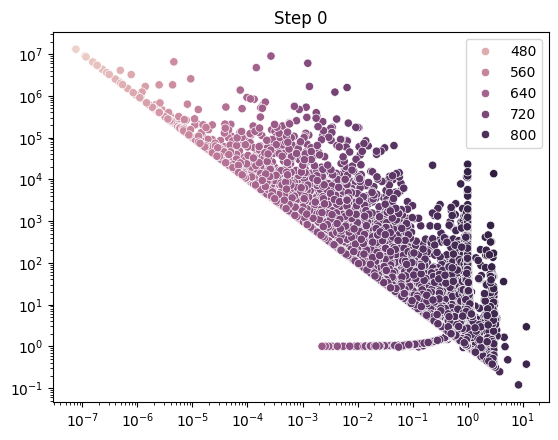

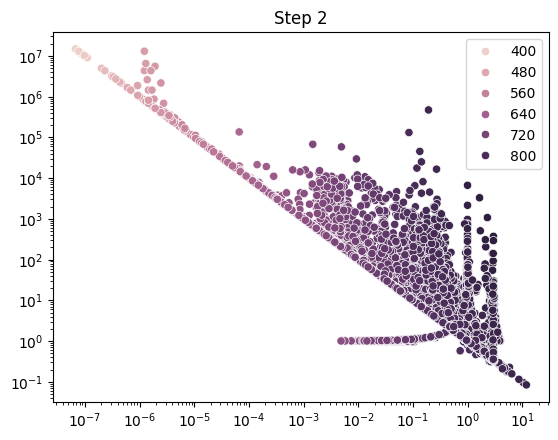

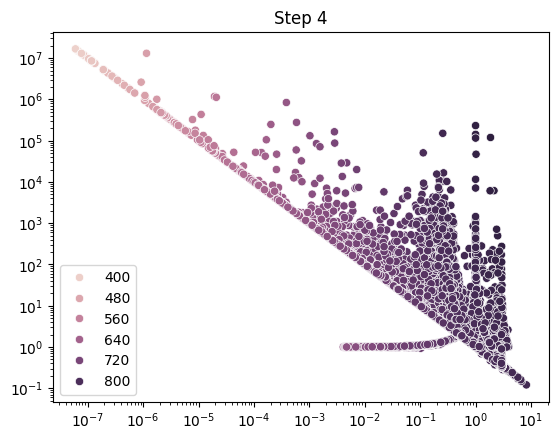

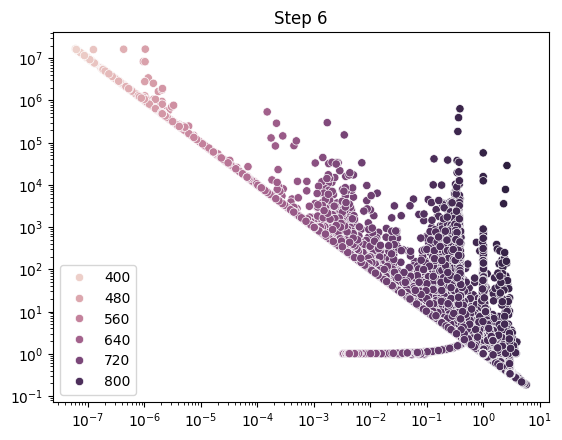

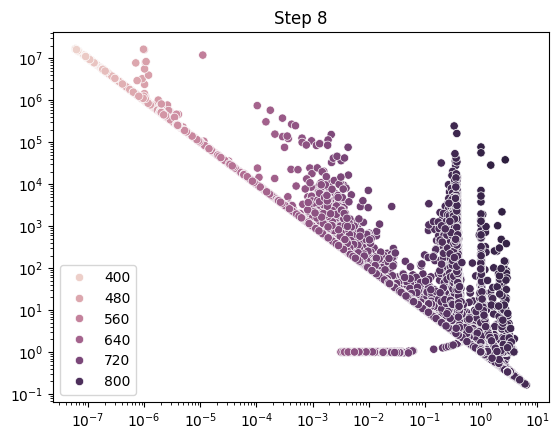

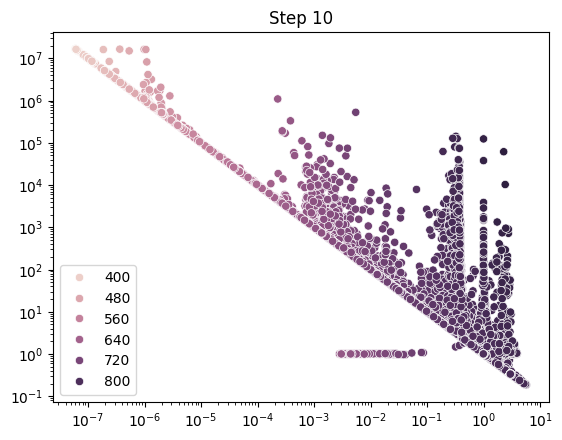

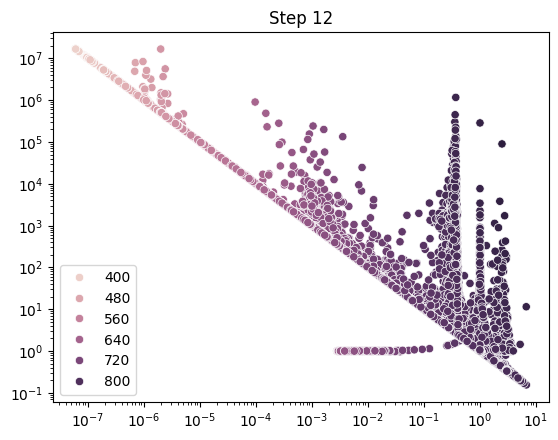

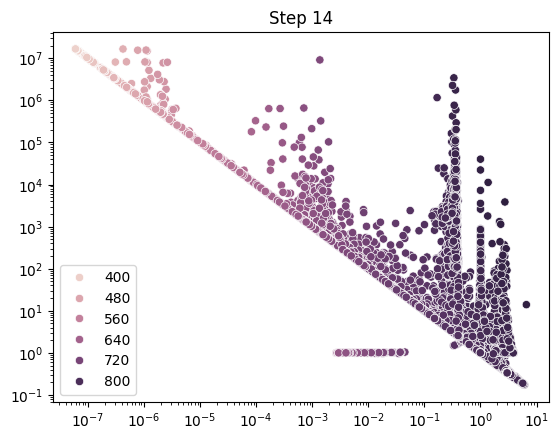

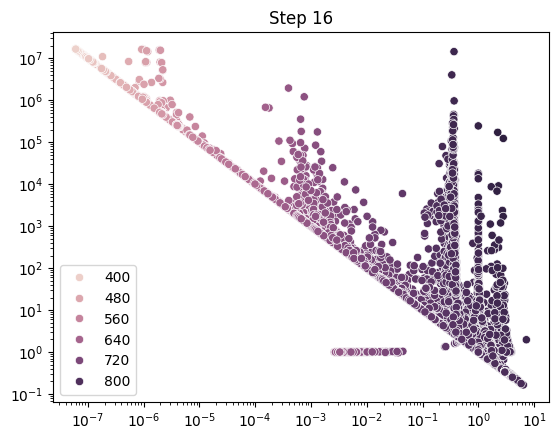

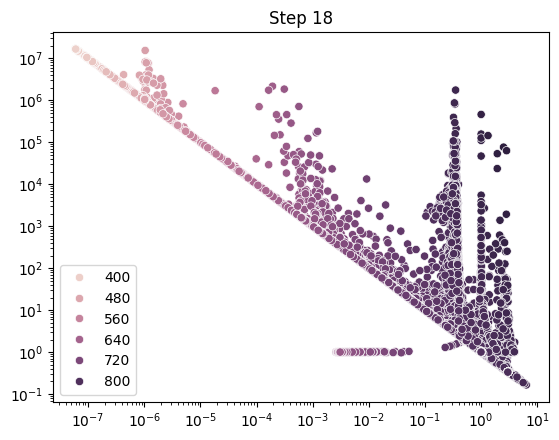

In [7]:
n_samples_per_parent = int(np.ceil(total_samples/choose_max))

# [total_steps, n_outputs, n_samples, n_reactions]
all_params_en = np.zeros((total_steps, *reverse_rates.shape))
all_params_eq = np.zeros((total_steps, *reverse_rates.shape))
all_params_rt = np.zeros((total_steps, *reverse_rates.shape))
all_is_parent = np.zeros((total_steps, total_samples), dtype=bool)
all_adaptability = np.zeros((total_steps, total_samples, len(species)))
all_sensitivity = np.zeros((total_steps, total_samples, len(species)))
all_precision = np.zeros((total_steps, total_samples, len(species)))

sim_func = jax.vmap(partial(bioreaction_sim_dfx_expanded,
                            t0=t0, t1=t1, dt0=dt0,
                            forward_rates=forward_rates,
                            inputs=inputs,
                            outputs=outputs,
                            solver=get_diffrax_solver(sim_method),
                            saveat=dfx.SaveAt(ts=jnp.linspace(t0, t1, 500)),
                            stepsize_controller=make_stepsize_controller(t0, t1, dt0, dt1, choice=stepsize_controller)))

curr_en = energies
for step in range(total_steps):

    print(f'\n\nStarting iteration {step+1} out of {total_steps}\n\n')

    curr_eq = jax.vmap(
        partial(equilibrium_constant_reparameterisation, initial=N0))(curr_en)
    _, curr_rt = eqconstant_to_rates(curr_eq, k_a)

    ys0, ts0, ys1, ts1 = simulate(
        y00, curr_rt, sim_func, t0, t1, tmax, batch_size, threshold_steady_state)
    next_idxs, adaptability, sensitivity, precision = choose_next(sol=(ys0, ys1), idxs_signal=idxs_signal, idxs_output=idxs_output,
                                                                  use_sensitivity_func1=use_sensitivity_func1, choose_max=choose_max, diversity=diversity)
    print(f'Choosing {len(next_idxs)} next circuits')
    
    if np.mod(step, 2) == 0:
        plt.figure()
        sns.scatterplot(x=sensitivity.flatten(), y=precision.flatten(), hue=adaptability.flatten())
        plt.xscale('log')
        plt.yscale('log')
        plt.title(f'Step {step}')

    # Save results
    all_params_en[step] = curr_en
    all_params_eq[step] = curr_eq
    all_params_rt[step] = curr_rt
    all_is_parent[step][next_idxs] = True
    all_adaptability[step] = adaptability
    all_sensitivity[step] = sensitivity
    all_precision[step] = precision

    # Mutate energies
    next_en = mutate_expand(
        curr_en[next_idxs], n_samples_per_parent, mutation_scale)[:total_samples]
    print(f'Mutated and expanding {len(next_idxs)} into {len(next_en)} next circuits')
    curr_en = next_en

# Visualise

Maxima - Adaptability: 860.8731689453125, Sensitivity: 11.634514808654785, Precision: inf
Maxima - Adaptability: 845.55712890625, Sensitivity: 14.882719039916992, Precision: inf


Maxima - Adaptability: 847.9185791015625, Sensitivity: 11.91715145111084, Precision: inf
Maxima - Adaptability: 855.958251953125, Sensitivity: 10.492329597473145, Precision: inf


Maxima - Adaptability: 858.2271728515625, Sensitivity: 8.249239921569824, Precision: inf
Maxima - Adaptability: 856.3656005859375, Sensitivity: 6.188015937805176, Precision: inf


Maxima - Adaptability: 860.8888549804688, Sensitivity: 5.811657428741455, Precision: inf
Maxima - Adaptability: 860.2586059570312, Sensitivity: 5.890548229217529, Precision: inf


Maxima - Adaptability: 862.060546875, Sensitivity: 6.43386173248291, Precision: inf
Maxima - Adaptability: 858.8017578125, Sensitivity: 6.574635982513428, Precision: inf


Maxima - Adaptability: 860.2526245117188, Sensitivity: 5.728428840637207, Precision: inf
Maxima - Adaptability: 857.837646484375, Sensitivity: 6.0908684730529785, Precision: inf


Maxima - Adaptability: 862.5477294921875, Sensitivity: 6.732540607452393, Precision: inf
Maxima - Adaptability: 853.1487426757812, Sensitivity: 6.8716840744018555, Precision: inf


Maxima - Adaptability: 855.395751953125, Sensitivity: 6.579568862915039, Precision: inf
Maxima - Adaptability: 869.9224243164062, Sensitivity: 6.190282344818115, Precision: inf


Maxima - Adaptability: 865.4137573242188, Sensitivity: 7.268969535827637, Precision: inf
Maxima - Adaptability: 852.684326171875, Sensitivity: 6.4458184242248535, Precision: inf


Maxima - Adaptability: 864.108642578125, Sensitivity: 6.387732028961182, Precision: inf
Maxima - Adaptability: 863.359130859375, Sensitivity: 6.623294353485107, Precision: inf


Text(0.5, 0.98, 'Monte Carlo sampling for higher adaptability')

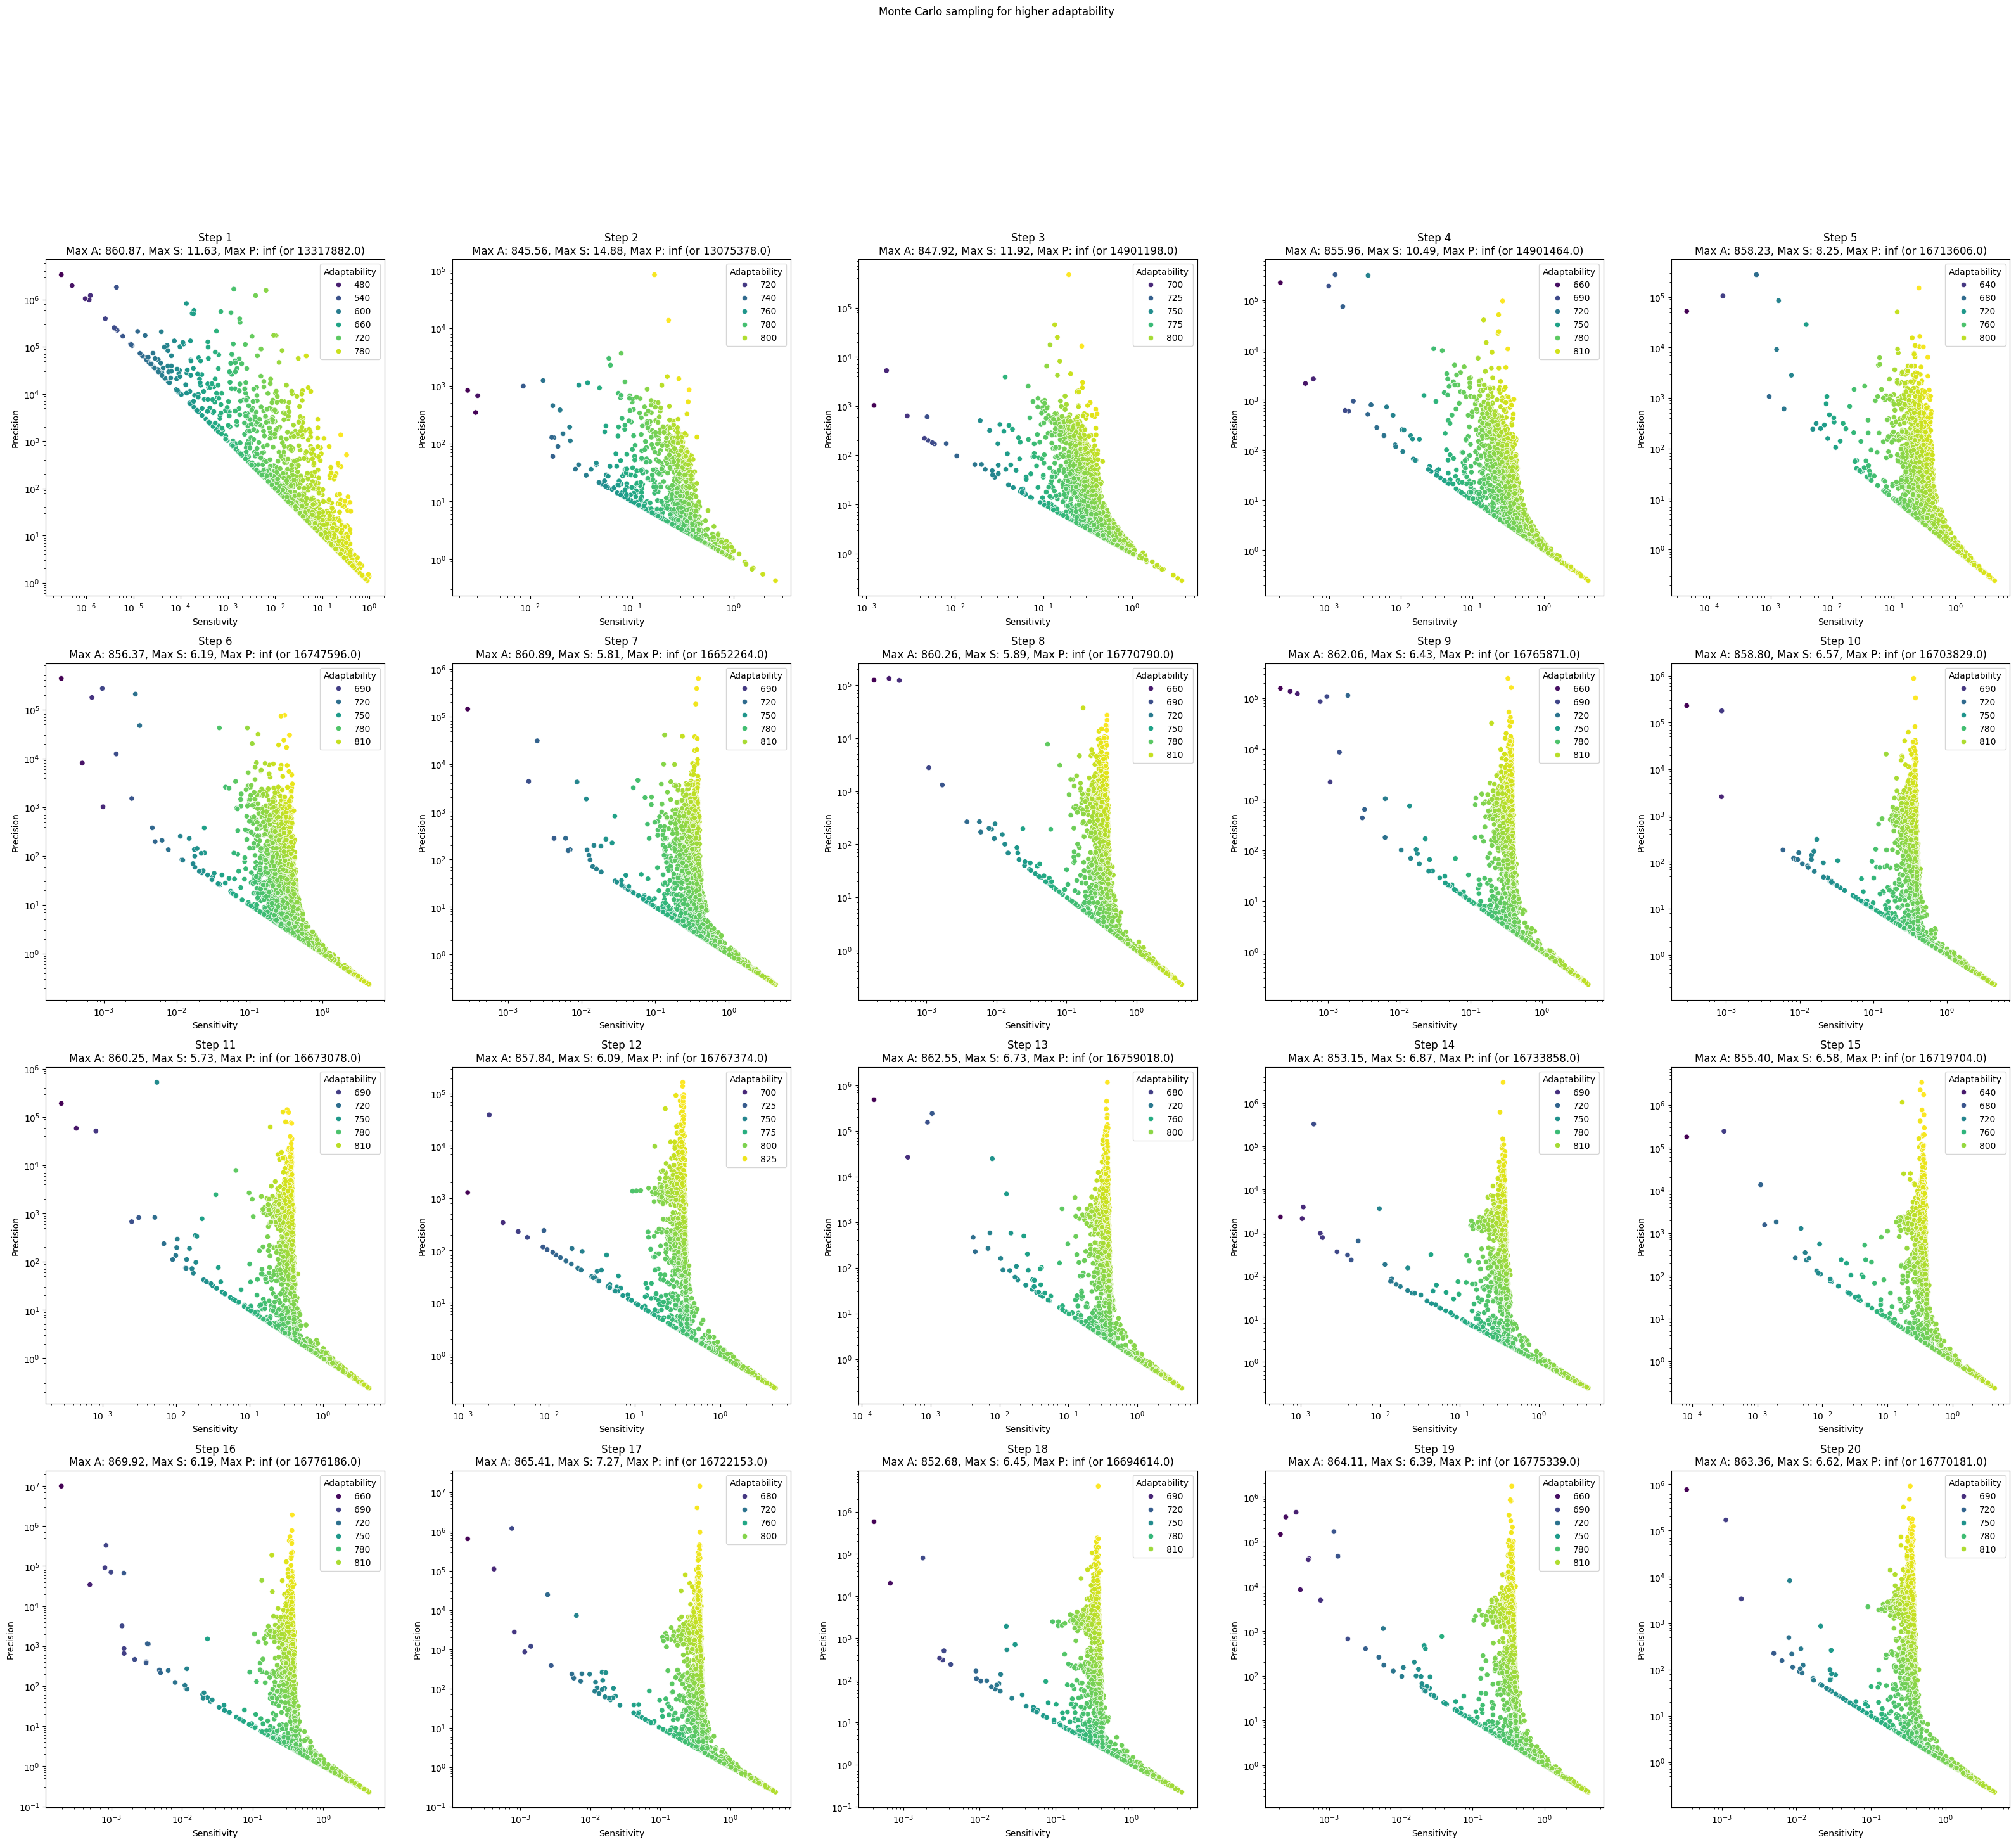

In [8]:
nc = int(np.ceil(np.sqrt(total_steps)))
nr = int(np.ceil(np.sqrt(total_steps)))
plt.figure(figsize=(8*nc, 8*nr))
d = pd.DataFrame(data={'Adaptability': all_adaptability[..., idxs_output].flatten(), 
                       'Sensitivity': all_sensitivity[..., idxs_output].flatten(), 
                       'Precision': all_precision[..., idxs_output].flatten(), 
                       'Is parent circuit': np.repeat(all_is_parent.flatten(), repeats=len(species_output)),
                       'Circuit idx': np.repeat(np.repeat(np.arange(total_samples), repeats=len(species_output)), repeats=total_steps),
                       'Species': flatten_listlike([[s] * total_samples for s in species_output] * total_steps),
                       'Step': np.repeat(np.arange(total_steps), repeats=total_samples*len(species_output)),
                       'Params energy': [l.tolist() for l in np.repeat(all_params_en.flatten(), repeats=len(species_output)).reshape(-1, energies.shape[-1])],
                       'Params equilibrium constants': [l.tolist() for l in np.repeat(all_params_eq.flatten(), repeats=len(species_output)).reshape(-1, energies.shape[-1])],
                       'Params rates': [l.tolist() for l in np.repeat(all_params_rt.flatten(), repeats=len(species_output)).reshape(-1, energies.shape[-1])]})
for step, (a, s, p) in enumerate(zip(all_adaptability, all_sensitivity, all_precision)):
    print(f'Maxima - Adaptability: {jnp.nanmax(a)}, Sensitivity: {jnp.nanmax(s)}, Precision: {jnp.nanmax(p)}')
    
    filt = (d['Step'] == step) & (d['Species'].isin(species_output))
    
    ax = plt.subplot(nr, nc, step+1)
    sns.scatterplot(d[filt], x='Sensitivity', y='Precision', hue='Adaptability', palette='viridis')
    plt.xscale('log')
    plt.yscale('log')
    plt.title(f'Step {step+1}\nMax A: {jnp.nanmax(a):.2f}, Max S: {jnp.nanmax(s):.2f}, Max P: {jnp.nanmax(p):.2f} (or {jnp.nanmax(p[p < np.inf])})')

plt.suptitle('Monte Carlo sampling for higher adaptability')

Maxima - Adaptability: nan, Sensitivity: nan, Precision: inf
Maxima - Adaptability: nan, Sensitivity: nan, Precision: inf
Maxima - Adaptability: nan, Sensitivity: nan, Precision: inf
Maxima - Adaptability: nan, Sensitivity: nan, Precision: inf
Maxima - Adaptability: nan, Sensitivity: nan, Precision: inf
Maxima - Adaptability: nan, Sensitivity: nan, Precision: inf
Maxima - Adaptability: nan, Sensitivity: nan, Precision: inf
Maxima - Adaptability: nan, Sensitivity: nan, Precision: inf
Maxima - Adaptability: nan, Sensitivity: nan, Precision: inf


Maxima - Adaptability: nan, Sensitivity: nan, Precision: inf
Maxima - Adaptability: nan, Sensitivity: nan, Precision: inf
Maxima - Adaptability: nan, Sensitivity: nan, Precision: inf
Maxima - Adaptability: nan, Sensitivity: nan, Precision: inf
Maxima - Adaptability: nan, Sensitivity: nan, Precision: inf
Maxima - Adaptability: nan, Sensitivity: nan, Precision: inf
Maxima - Adaptability: nan, Sensitivity: nan, Precision: inf
Maxima - Adaptability: nan, Sensitivity: nan, Precision: inf
Maxima - Adaptability: nan, Sensitivity: nan, Precision: inf


Maxima - Adaptability: nan, Sensitivity: nan, Precision: inf
Maxima - Adaptability: nan, Sensitivity: nan, Precision: inf


Text(0.5, 0.98, 'Monte Carlo sampling for higher adaptability')

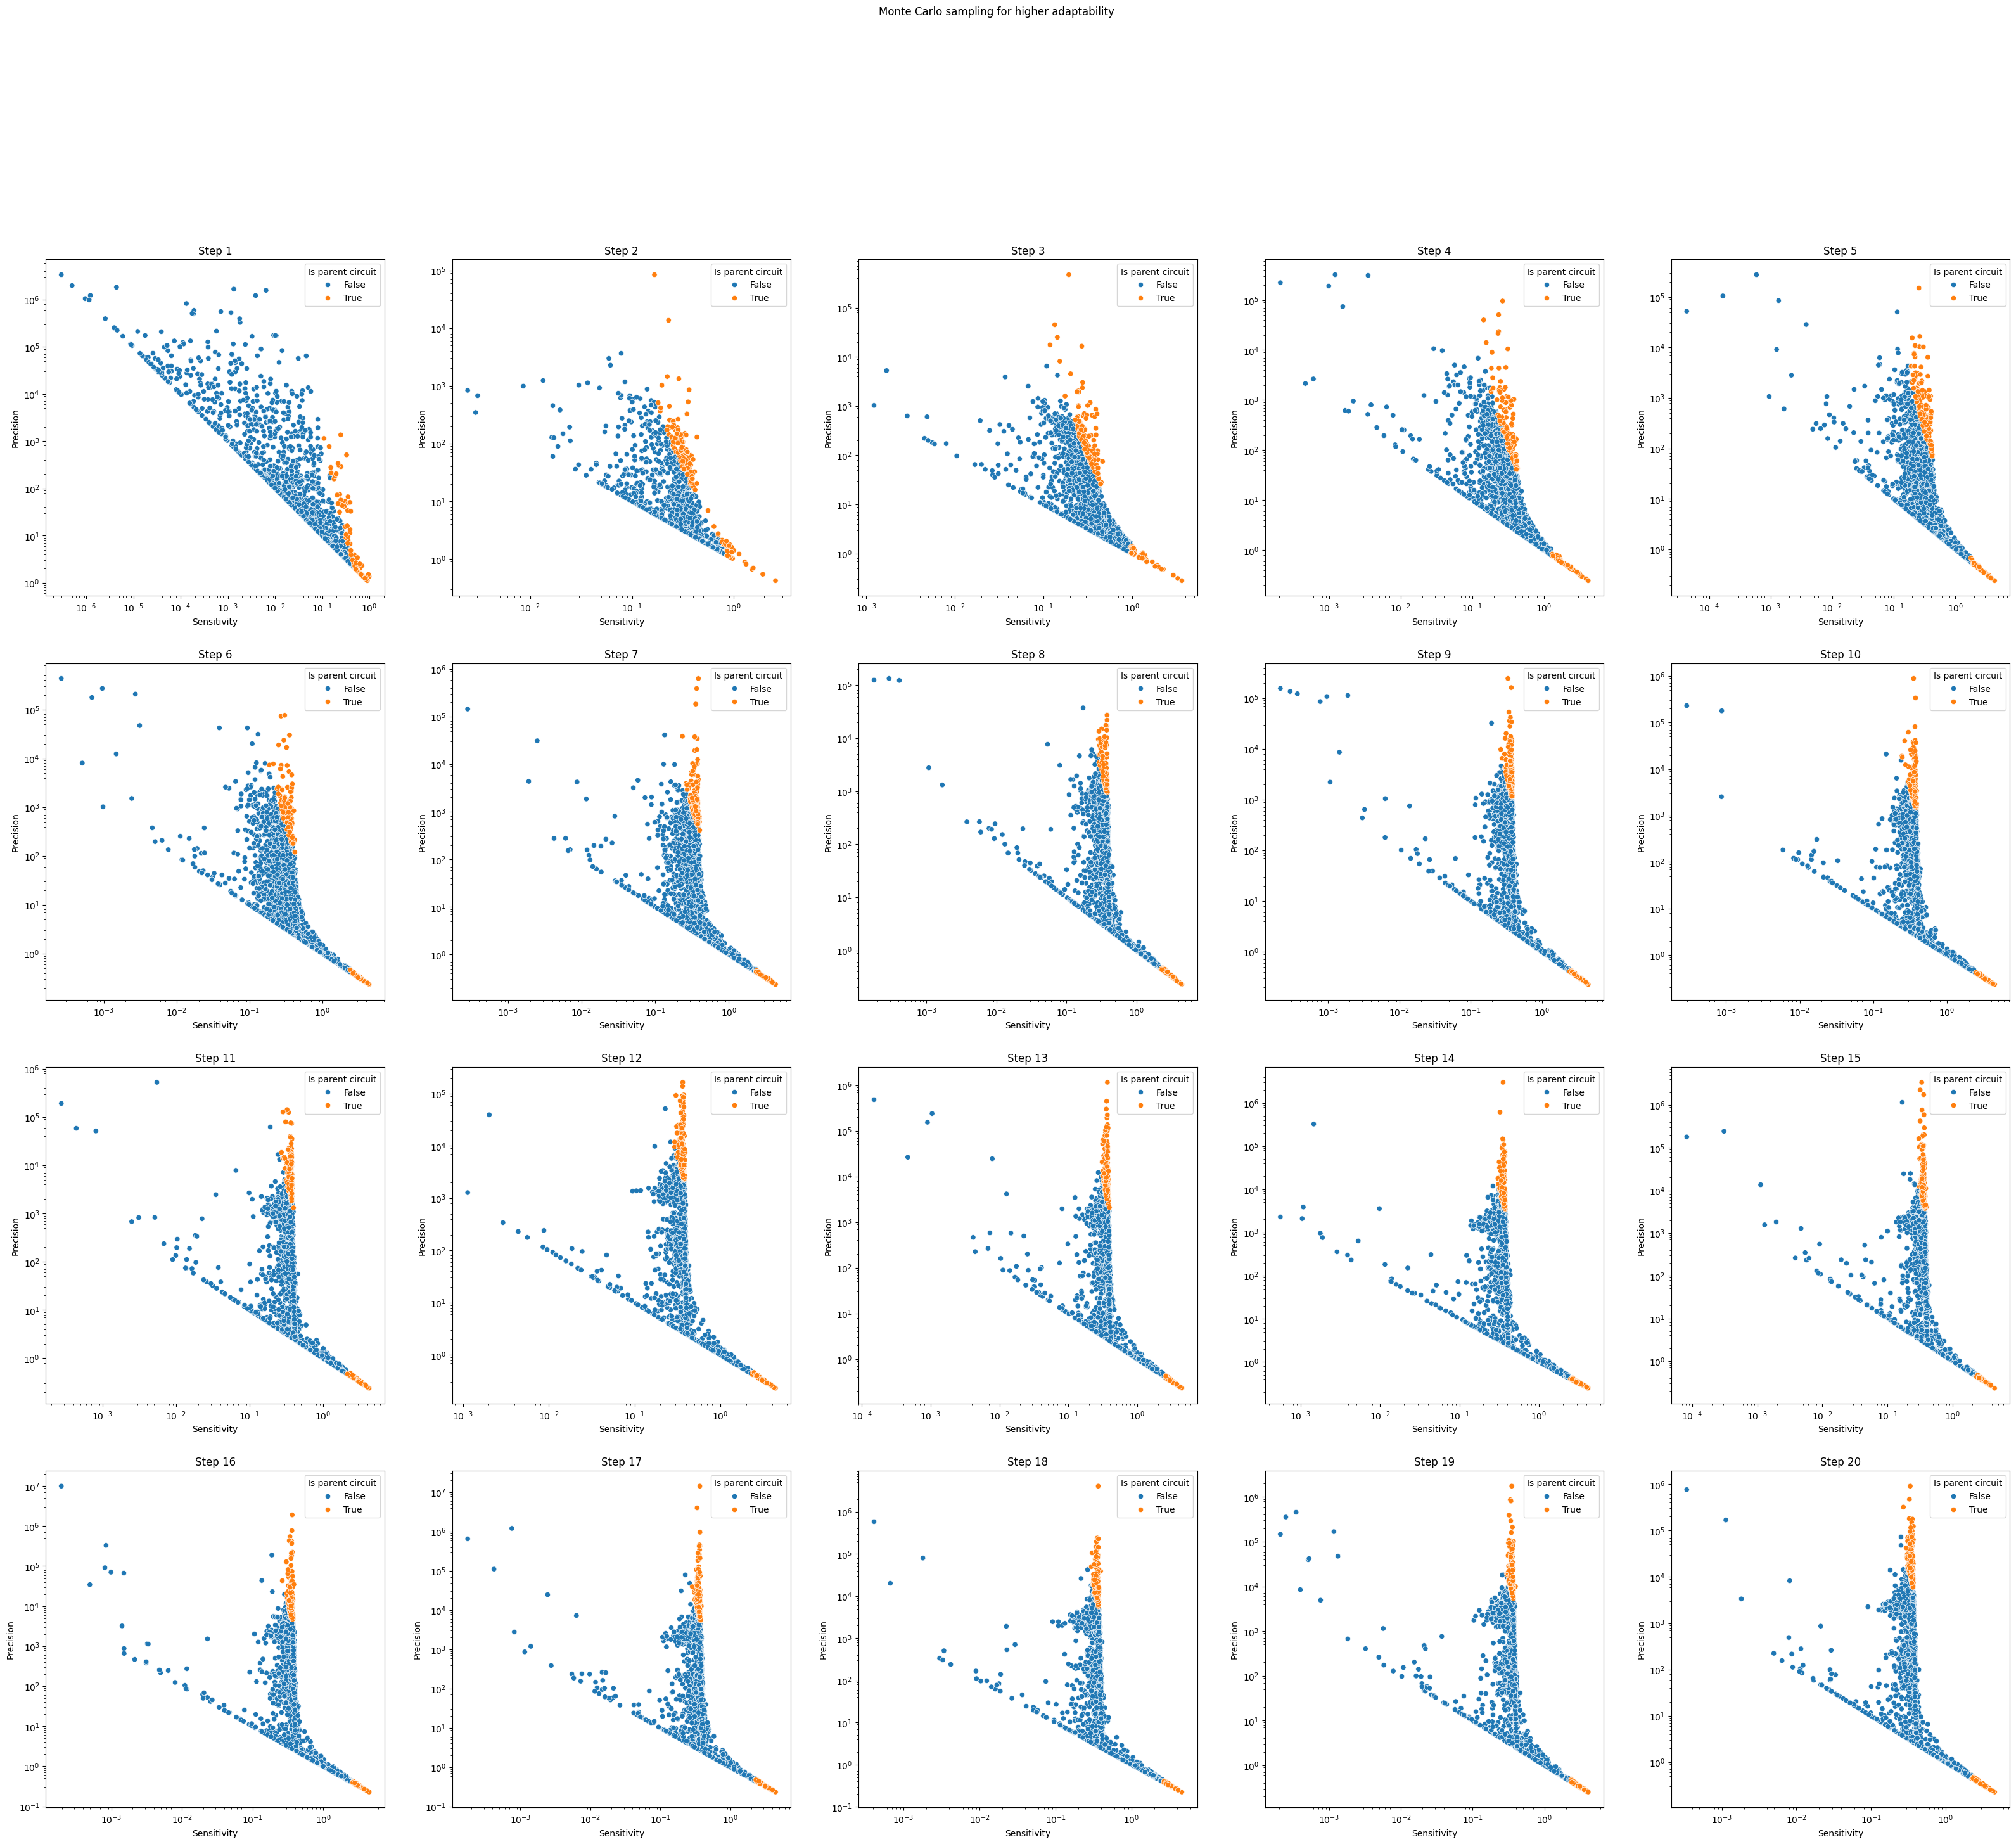

In [9]:
nc = int(np.ceil(np.sqrt(total_steps)))
nr = int(np.ceil(np.sqrt(total_steps)))
plt.figure(figsize=(8*nc, 8*nr))
for step, (a, s, p) in enumerate(zip(all_adaptability, all_sensitivity, all_precision)):
    print(f'Maxima - Adaptability: {a.max()}, Sensitivity: {s.max()}, Precision: {p.max()}')
    
    filt = (d['Step'] == step) & (d['Species'].isin(species_output))
    ax = plt.subplot(nr, nc, step+1)
    sns.scatterplot(d[filt].sort_values(by='Is parent circuit'), x='Sensitivity', y='Precision', hue='Is parent circuit')
    plt.xscale('log')
    plt.yscale('log')
    plt.title(f'Step {step+1}')

plt.suptitle('Monte Carlo sampling for higher adaptability')

## Visualise histograms

Text(0.5, 1.0, 'Precision')

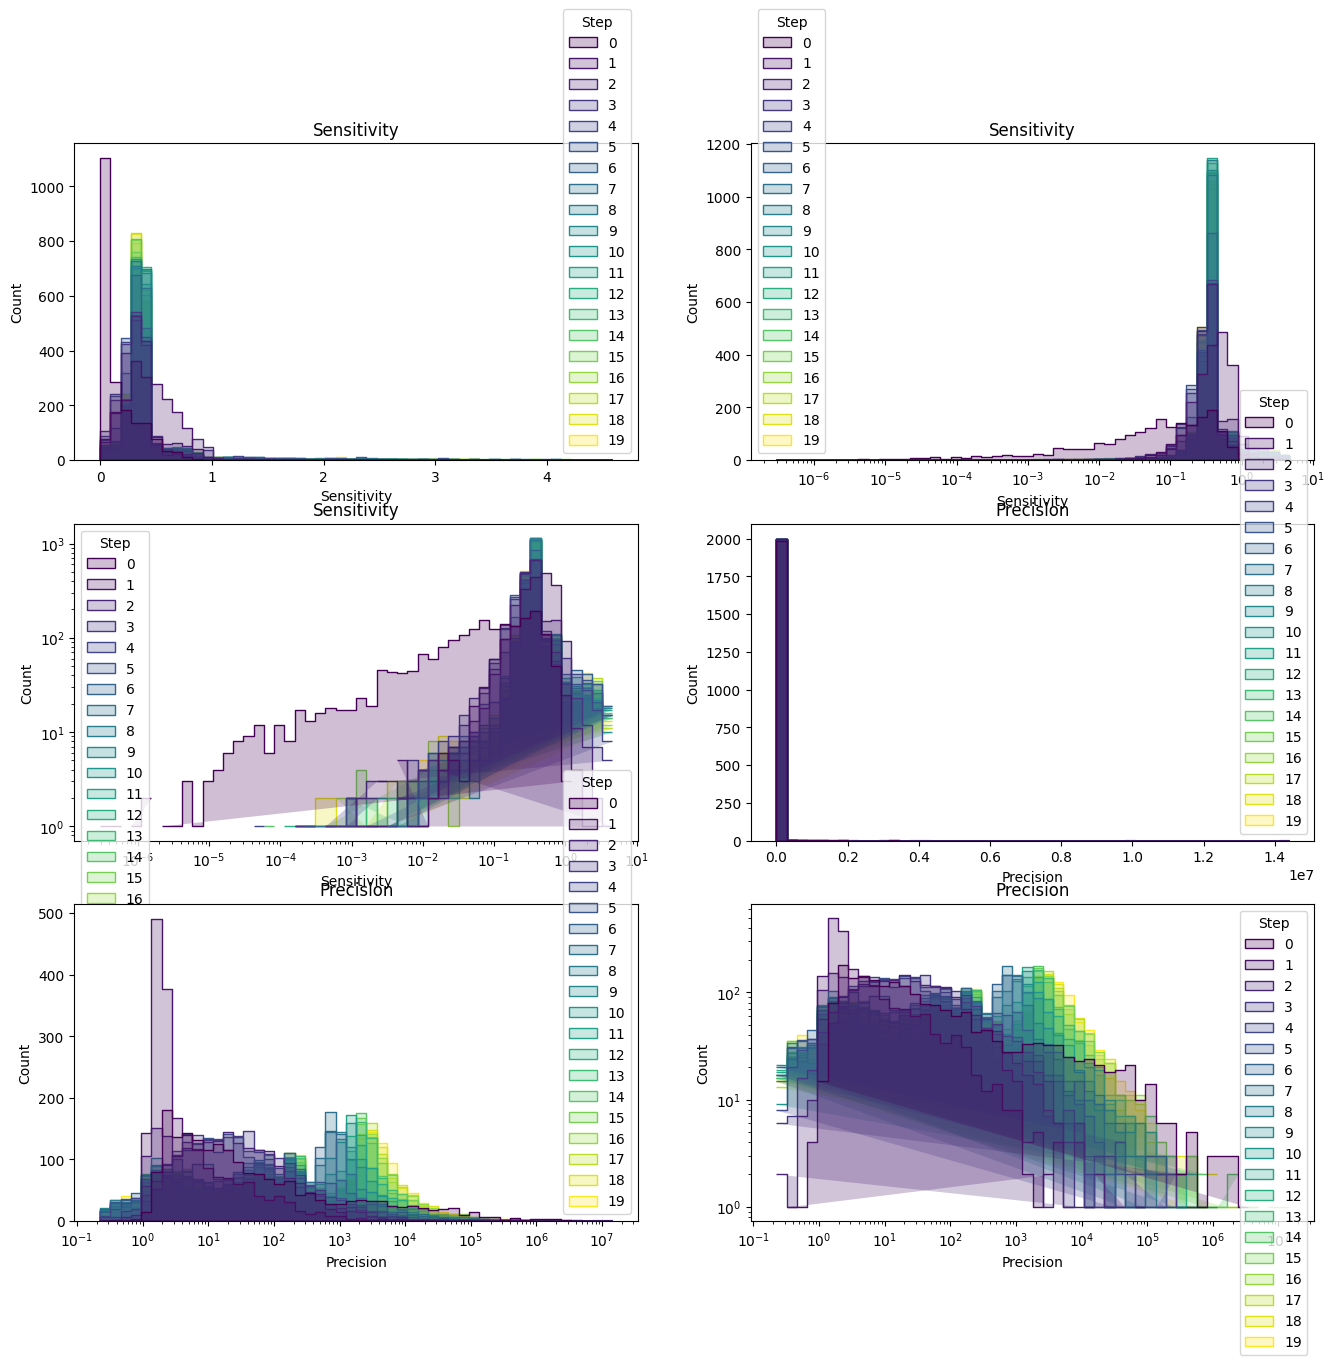

In [10]:
fig = plt.figure(figsize=(8*2, 7*2))
ax = plt.subplot(3, 2, 1)
sns.histplot(d[d['Species'].isin(species_output)], x='Sensitivity', hue='Step', log_scale=[False, False], bins=50, element='step', palette='viridis')
plt.title('Sensitivity')
ax = plt.subplot(3, 2, 2)
sns.histplot(d[d['Species'].isin(species_output)], x='Sensitivity', hue='Step', log_scale=[True, False], bins=50, element='step', palette='viridis')
plt.title('Sensitivity')
ax = plt.subplot(3, 2, 3)
sns.histplot(d[d['Species'].isin(species_output)], x='Sensitivity', hue='Step', log_scale=[True, True], bins=50, element='step', palette='viridis')
plt.title('Sensitivity')
ax = plt.subplot(3, 2, 4)
sns.histplot(d[d['Species'].isin(species_output)], x='Precision', hue='Step', log_scale=[False, False], bins=50, element='step', palette='viridis')
plt.title('Precision')
ax = plt.subplot(3, 2, 5)
sns.histplot(d[d['Species'].isin(species_output)], x='Precision', hue='Step', log_scale=[True, False], bins=50, element='step', palette='viridis')
plt.title('Precision')
ax = plt.subplot(3, 2, 6)
sns.histplot(d[d['Species'].isin(species_output)], x='Precision', hue='Step', log_scale=[True, True], bins=50, element='step', palette='viridis')
plt.title('Precision')


In [11]:
d.sort_values(by='Adaptability', ascending=False).head(10)

Adaptability  Sensitivity     Precision  Is parent circuit  \
32545    834.006897     0.366552  1.439166e+07               True   
34363    833.182739     0.363782  4.063727e+06               True   
31035    832.450073     0.363100  1.902003e+06               True   
27397    832.395752     0.353807  3.015780e+06               True   
13424    832.301758     0.387133  6.357794e+05               True   
25863    832.212219     0.369399  1.159408e+06               True   
28451    832.178040     0.359520  1.765780e+06               True   
33116    831.915771     0.368211  9.658494e+05               True   
37972    831.695740     0.350858  1.751526e+06               True   
33018    831.539185     0.334433  4.017170e+06               True   

       Circuit idx Species  Step  \
32545         1627   RNA_2    16   
34363         1718   RNA_2    17   
31035         1551   RNA_2    15   
27397         1369   RNA_2    13   
13424          671   RNA_2     6   
25863         1293   RNA_2    12   
28451         1422   RNA_2    14   
33116         1655   RNA_2    16   
37972         1898   RNA_2    18   
33018         1650   RNA_2    16   

                                           Params energy  \
32545  [-0.6703937649726868, -0.8651988506317139, -11...   
34363  [-0.6461842060089111, -0.6556981801986694, -11...   
31035  [-0.2916331887245178, -1.2521716356277466, -11...   
27397  [-0.7438141703605652, -0.9114807844161987, -11...   
13424  [-0.651785671710968, -12.02252197265625, -11.1...   
25863  [-0.9035243391990662, -0.951898455619812, -11....   
28451  [-0.2833828628063202, -1.228995680809021, -11....   
33116  [-0.9358639717102051, -0.733168363571167, -11....   
37972  [-0.6315923929214478, -0.7718314528465271, -11...   
33018  [-0.8854568600654602, -0.6256574392318726, -11...   

                            Params equilibrium constants  \
32545  [2.867693865482579e-06, 3.3513133530505e-06, 0...   
34363  [2.8126876259193523e-06, 2.834176029864466e-06...   
31035  [2.1180590010771994e-06, 4.567336873151362e-06...   
27397  [3.0411765692406334e-06, 3.4777231121552177e-0...   
13424  [2.825320279953303e-06, 0.02521541342139244, 0...   
25863  [3.4556567243271274e-06, 3.59201089850103e-06,...   
28451  [2.10412395063031e-06, 4.483434622670757e-06, ...   
33116  [3.546225343598053e-06, 3.0153869374771602e-06...   
37972  [2.780045861072722e-06, 3.1101101285457844e-06...   
33018  [3.4060681173286866e-06, 2.7668752409226727e-0...   

                                            Params rates  
32545  [526.4093627929688, 450.444580078125, 0.070071...  
34363  [536.7041015625, 532.6348876953125, 0.07377805...  
31035  [712.7190551757812, 330.51666259765625, 0.0749...  
27397  [496.380615234375, 434.0716552734375, 0.089496...  
13424  [534.3043823242188, 0.059867389500141144, 0.11...  
25863  [436.84344482421875, 420.2607116699219, 0.0653...  
28451  [717.439208984375, 336.701904296875, 0.0804236...  
33116  [425.68670654296875, 500.6259765625, 0.0669581...  
37972  [543.0057983398438, 485.3786315917969, 0.09491...  
33018  [443.2033996582031, 545.590576171875, 0.123771...

In [12]:
d.sort_values(by='Adaptability', ascending=False).to_csv('23_Monte_Carlo_adaptability.csv', index=False)